In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
import sys
import numpy as np

sys.path.insert(0,'../data_utils/')
from Sample import Sample
from OrigamiTransform import OrigamiTransform
from ConfigDataset import ConfigDataset
origami_transform = OrigamiTransform()

sys.path.insert(1,'../diffusion_compartmental/model_files/')
from GaussianDiffusion import GaussianDiffusion
from Unet_no_embed_reduction import Unet

plt.style.use('/home/gridsan/gschuette/universal/matplotlib/plot_style.txt')

In [2]:
segment_length = 64
remove_diagonal = False

use_origami = True

#chrom = '1'
chrom = '1'
region_idx = 330

ntrials = 100

config_fp = '../../data/processed_data.hdf5'
embedding_dir = '../../data/embeddings_64_after_transformer/'
embedding_dimensions = (1,256,256)
mean_dist_fp = '../../data/mean_dists.pt'
mean_sq_dist_fp='../../data/squares.pt'

model_fp = '../../data/models/diffusion_origami_64_no_embed_reduction/model-120.pt'

save_folder = './Repaint/'

#unguided_fp = '../../data/samples/origami_64_no_embed_reduction/sample_unguided_milestone_120_combined.pt'
#unguided_fp = '../../data/samples/origami_64_no_embed_reduction/sample_144_3.0_1.0_36_1.pt'

In [3]:
if not os.path.exists(save_folder):
    os.makedirs(save_folder) 

Build the dataset & support 

In [4]:
embedding_idx = pd.read_pickle(embedding_dir + '/rosetta_stone.pkl')

In [5]:
config_ds = ConfigDataset(
    config_fp,
    segment_length=segment_length,
    remove_diagonal=remove_diagonal,
    batch_size=0,
    normalize_distances=True,
    geos=None,
    organisms=None,
    cell_types=None,
    cell_numbers=None,
    chroms=[chrom],
    replicates=None,
    shuffle=True,
    allow_overlap=True,
    two_channels=False,
    try_GPU=True,
    mean_dist_fp=mean_dist_fp,
    mean_sq_dist_fp=mean_sq_dist_fp
)

In [6]:
def remove_diagonal_fcn(mat):

    n = mat.shape[-1]
    mat2 = torch.empty(
        *mat.shape[:-2],n-1,n-1,
        dtype=mat.dtype,
        device=mat.device
    )
    i,j = torch.triu_indices(n,n,1)
    mat2[...,i,j-1] = mat[...,i,j]
    mat2[...,j-1,i] = mat[...,j,i]

    return mat2

def add_diagonal_fcn(mat,diag_value=0):

    n = mat.shape[-1]
    mat2 = torch.empty(
        *mat.shape[:-2],n+1,n+1,
        dtype=mat.dtype,
        device=mat.device
    )
    i,j = torch.triu_indices(n,n,0)
    mat2[...,i,j+1] = mat[...,i,j]
    mat2[...,j+1,i] = mat[...,j,i]
    i = torch.arange(n+1)
    mat2[...,i,i] = diag_value

    return mat2

In [7]:
def genomic_to_coord_idx(chrom,genomic_idx,config_ds=config_ds):
    '''
    Returns starting index of the first instance of this region of the genome (for cell type, lineage, etc.) 
    '''
    config_info = config_ds.fetch_specific_coords(chrom,genomic_idx)[0].loc[0,:]
    
    inner_min = config_ds.coord_info[
        (config_ds.coord_info.Cell == config_info.Cell) & 
        (config_ds.coord_info.Chromosome == chrom) &
        (config_ds.coord_info.Replicate == config_info.Replicate)
    ]
    
    if len(inner_min) == 0: # The selection is invalid 
        return False, False

    inner_min, inner_max = int(inner_min.idx_min.values), int(inner_min.idx_max.values)

    temp_gen_idx = config_ds.genomic_index[inner_min:inner_max]
    if temp_gen_idx[-1] < genomic_idx: 
        return False, False # The requested region is out of range
    
    start = np.where(
        temp_gen_idx == genomic_idx
    )[0] + inner_min

    if len(start) == 0:
        return False, False # The index doesn't exist 
    start = int(start) # for indexing below

    return start

In [8]:
def fetch_config(region_idx,chrom=chrom,embedding_idx=embedding_idx,config_ds=config_ds):
    _,chrom_,genomic_idx = embedding_idx[chrom][region_idx] 
    assert chrom == chrom_
    
    simple_idx = genomic_to_coord_idx(chrom,genomic_idx,config_ds)

    return config_ds.fetch(simple_idx)[0,0,...] # maternal copy
    

In [9]:
fetch_config(region_idx,chrom).shape

torch.Size([64, 64])

Build the diffusion model 

In [10]:
c,image_size = 2,segment_length//2
unet = Unet(
    dim=64,
    cond_drop_prob = 0.5,
    init_dim = None,
    out_dim = None,
    dim_mults=(1, 2, 4, 8),
    channels = c,
    resnet_block_groups = 8,
    learned_variance = False,
    learned_sinusoidal_cond = False,
    random_fourier_features = False,
    learned_sinusoidal_dim = 16,
    attn_dim_head = 32,
    attn_heads = 4,
    embedding_dimensions=embedding_dimensions
)

#torch.save(model,'test_size.pt') # 2.2 GB

diffusion = GaussianDiffusion(
    unet,
    #embedder=Flatten(),#nn.Identity(),#embedder,
    image_size=image_size,
    timesteps = 1000,
    sampling_timesteps = None,
    objective = 'pred_noise',
    beta_schedule = 'cosine',
    ddim_sampling_eta = 1.,
    offset_noise_strength = 0.,
    min_snr_loss_weight = False,
    min_snr_gamma = 5
).to('cuda' if torch.cuda.is_available() else None)

diffusion.load(model_fp)

Get the original image, generate a scHi-C mask

In [34]:
# Set the properties to generate scHi-C map
r_c = 2
p_drop = .5#0.

# Get the config
desired_config = fetch_config(region_idx,chrom)

# Make a copy for the model 
config_for_model = desired_config.clone()

# Unnormalize the desired fig for plotting purposes
if remove_diagonal:
    desired_config = Sample(data = desired_config)
else:
    desired_config = Sample(data = remove_diagonal_fcn(desired_config))
desired_config.unnormalize_()
desired_config = add_diagonal_fcn(desired_config.unflatten())

# Create a scHi-C mask 
if remove_diagonal:
    keep_mask = remove_diagonal_fcn(desired_config) < r_c
else:
    keep_mask = desired_config < r_c    
keep_mask[torch.rand_like(desired_config) < p_drop] = False

# Manipulate the objects' shapes for use in the diffusion model
if use_origami:
    config_for_model = origami_transform(config_for_model)
    keep_mask_for_model = origami_transform(keep_mask)
else: 
    config_for_model = desired_config.clone()
    keep_mask_for_model = keep_mask.clone()

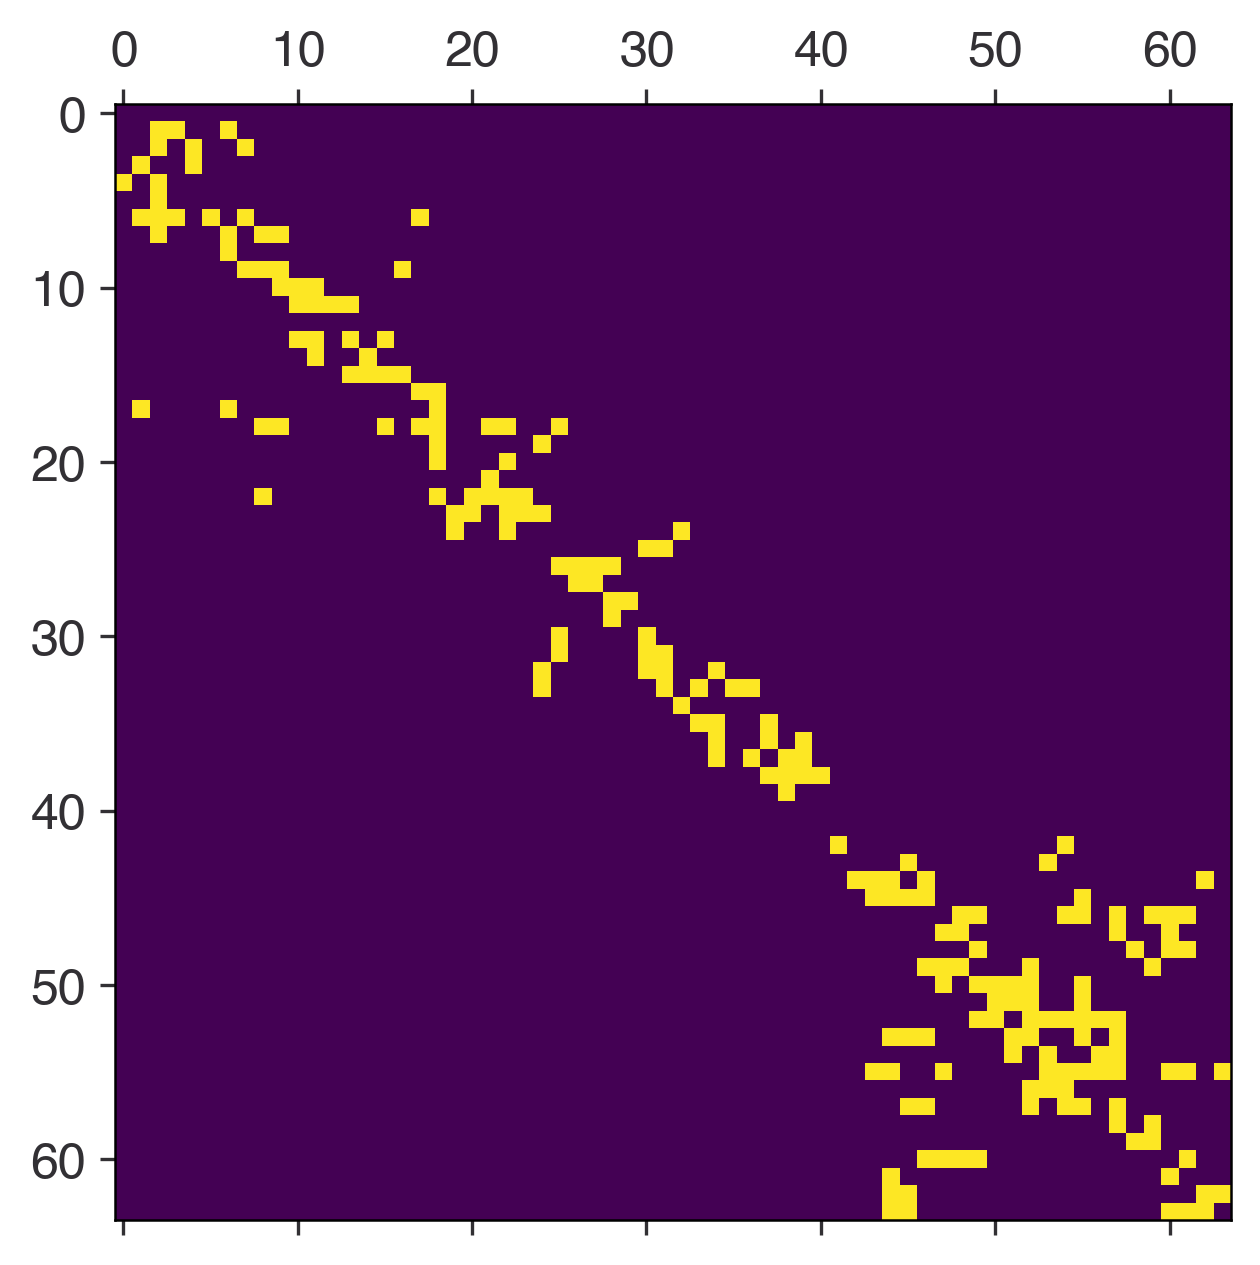

In [12]:
# Show the scHi-C map as a sanity check
plt.matshow(keep_mask.to(torch.float).cpu().numpy())

Perform repainting procedure! 

In [13]:
reconstructed_images = diffusion.repaint(input_image=config_for_model,keep_mask=keep_mask_for_model,num_trials=ntrials,n_repeats=20)

Repainting loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
torch.save(reconstructed_images,save_folder+'/reconstructed_images.pt')

Unnormalize the data, etc. 

In [15]:
sample = Sample(
    data = remove_diagonal_fcn(origami_transform.inverse(reconstructed_images))
)
sample.unnormalize_()
recon = add_diagonal_fcn(sample.unflatten())

Plot the maps 

In [33]:
def plot_dists(dist_map):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.matshow(dist_map.cpu().numpy(),cmap='cividis',vmin=desired_config.min().cpu().numpy(),vmax=desired_config.max().cpu().numpy())
    cbar = fig.colorbar(im) 
    cbar.set_label('Distance Between Monomers (Mean Bond Length)')
    ax.set_xlabel('Monomer Index')
    ax.set_ylabel('Monomer Index')
    ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    return fig, ax, im, cbar

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 38 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'L', 'M', 'T', 'a', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'i', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'w', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 19, 20, 21, 22, 23, 24, 25, 27, 37, 38, 39, 44, 47, 48, 55, 68, 70, 71, 72, 73, 74, 75, 76, 80, 81, 82, 85, 86, 87, 88, 90, 91]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 39 glyphs after
INFO:fontTools.subset:Glyph names: ['.notde

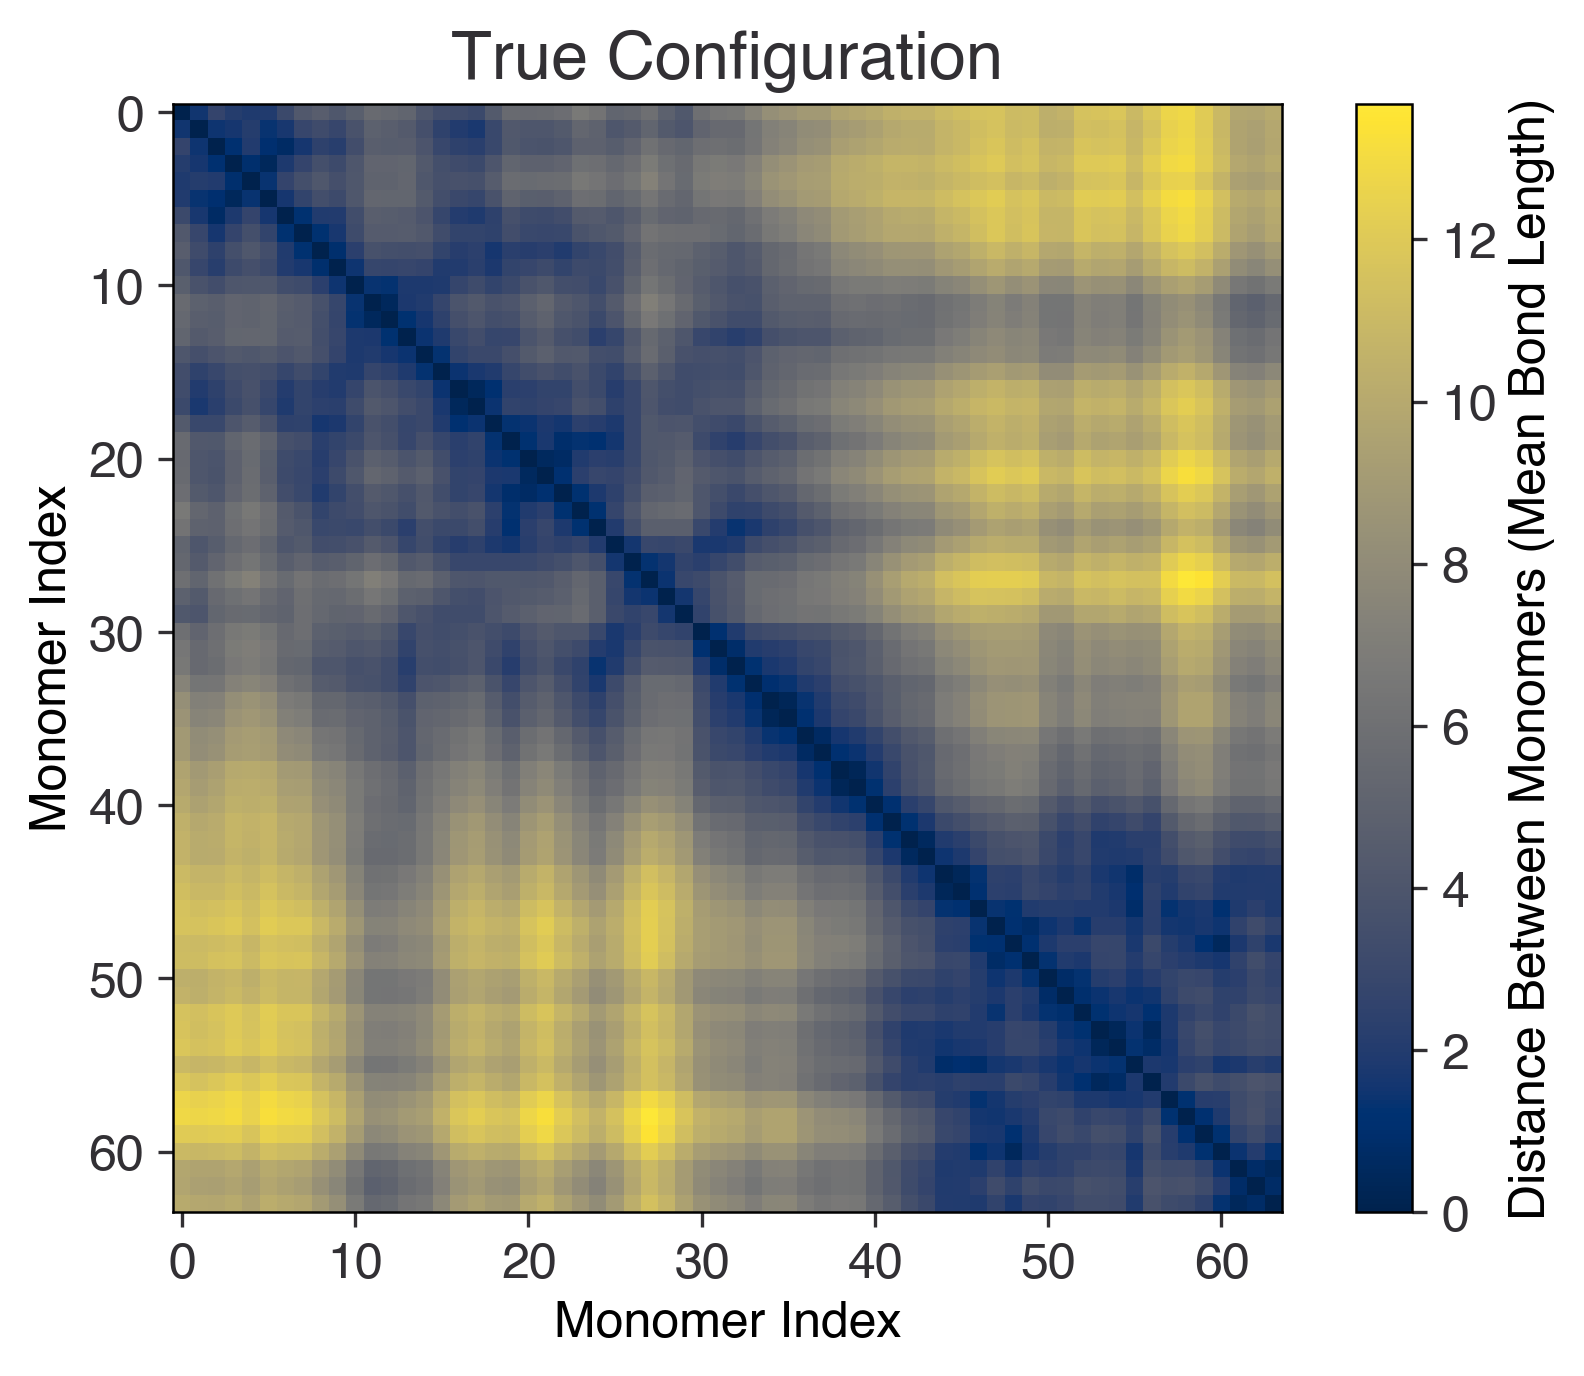

In [17]:
fig,ax,*_ = plot_dists(desired_config)
ax.set_title('True Configuration')

fig.savefig('dist_map_true.pdf')

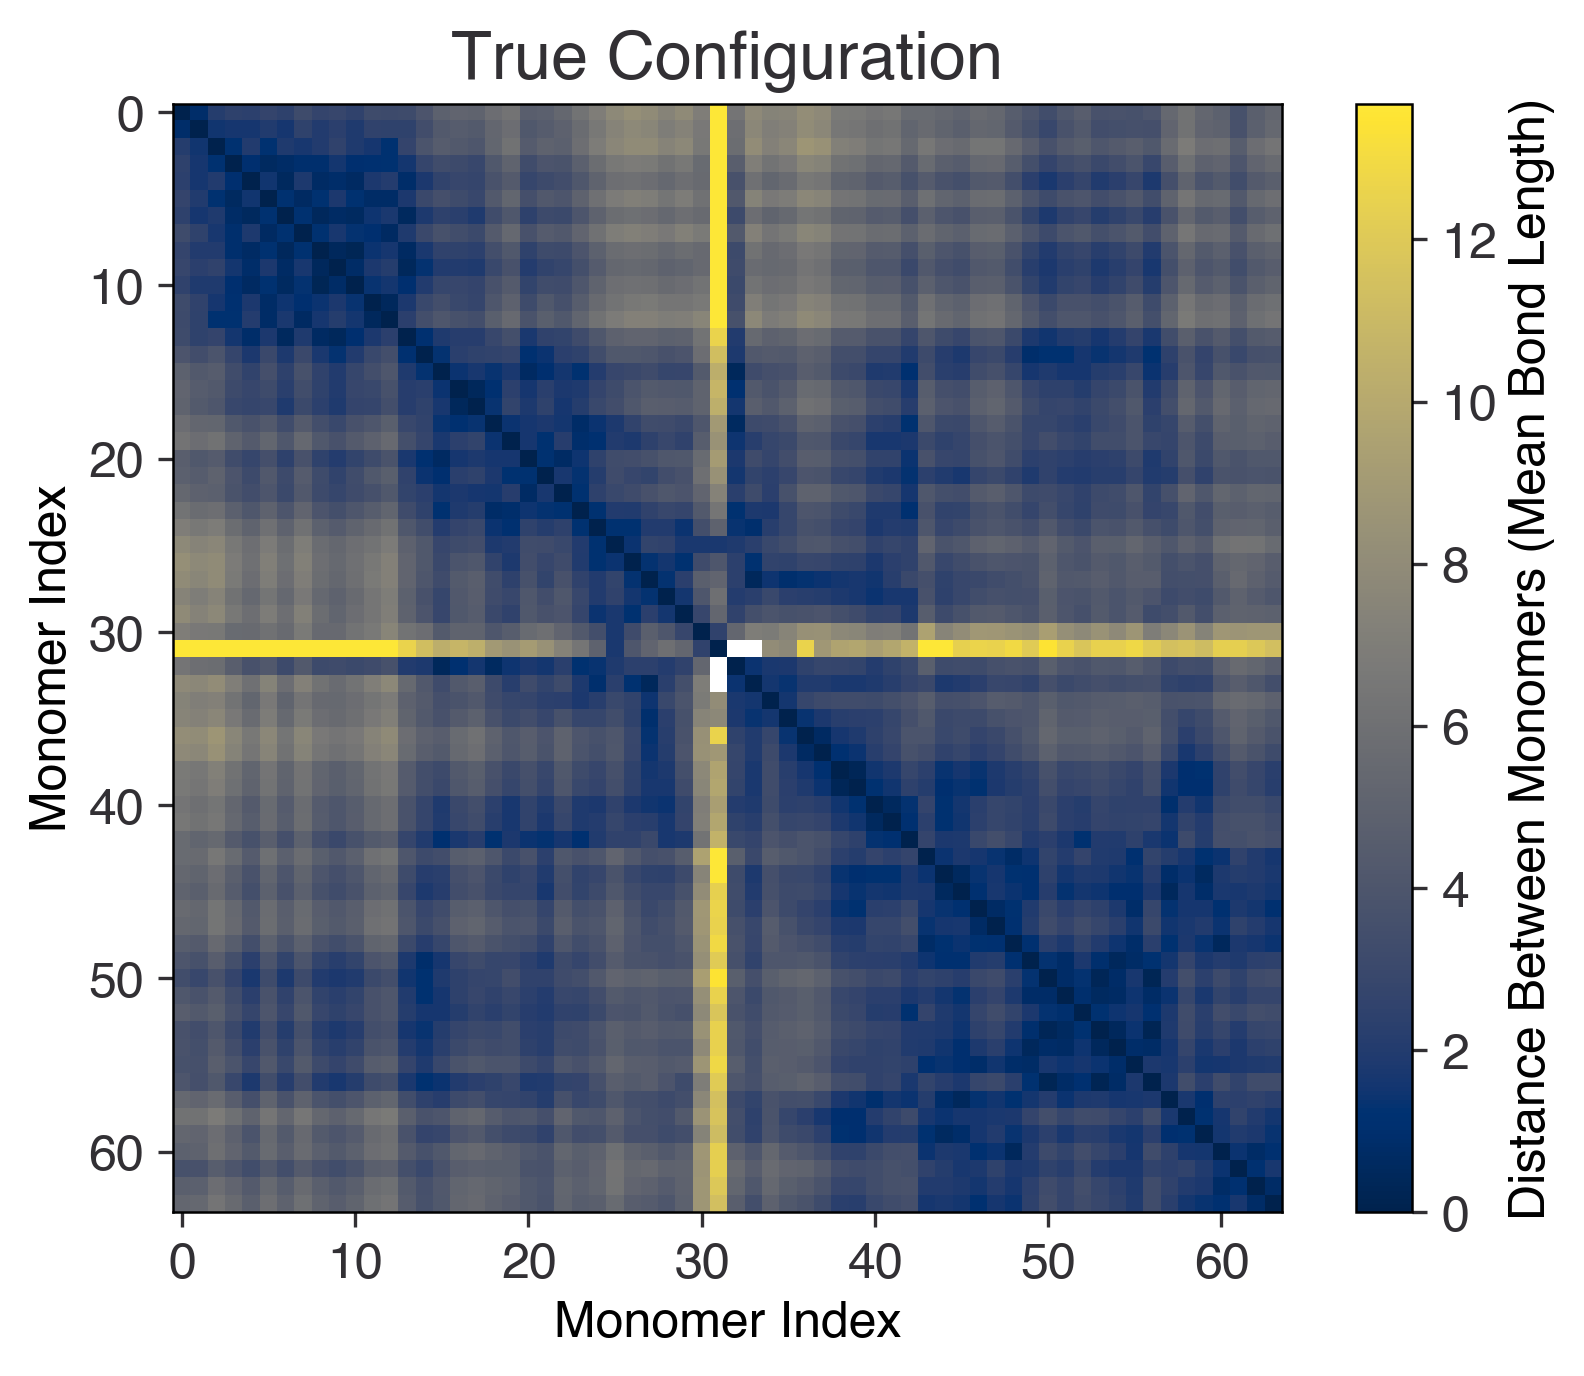

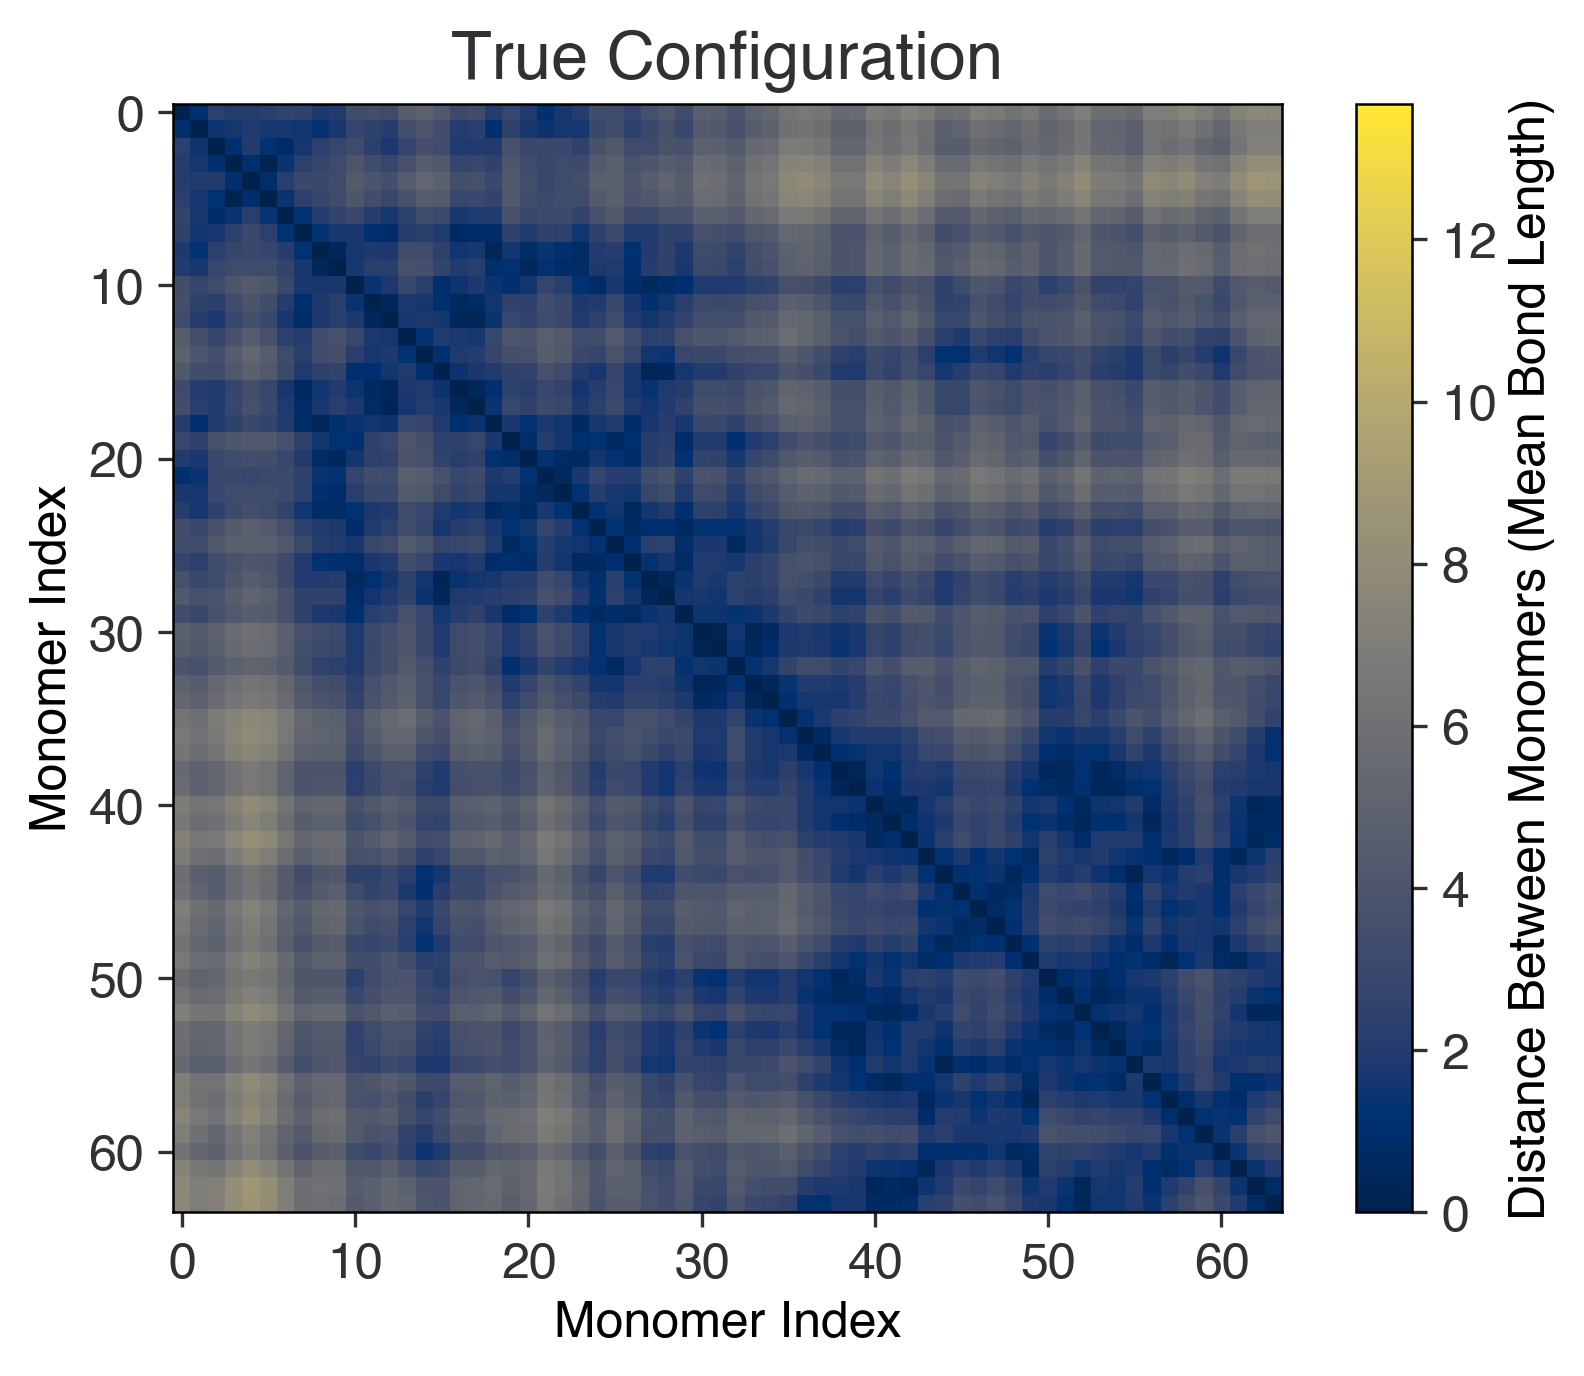

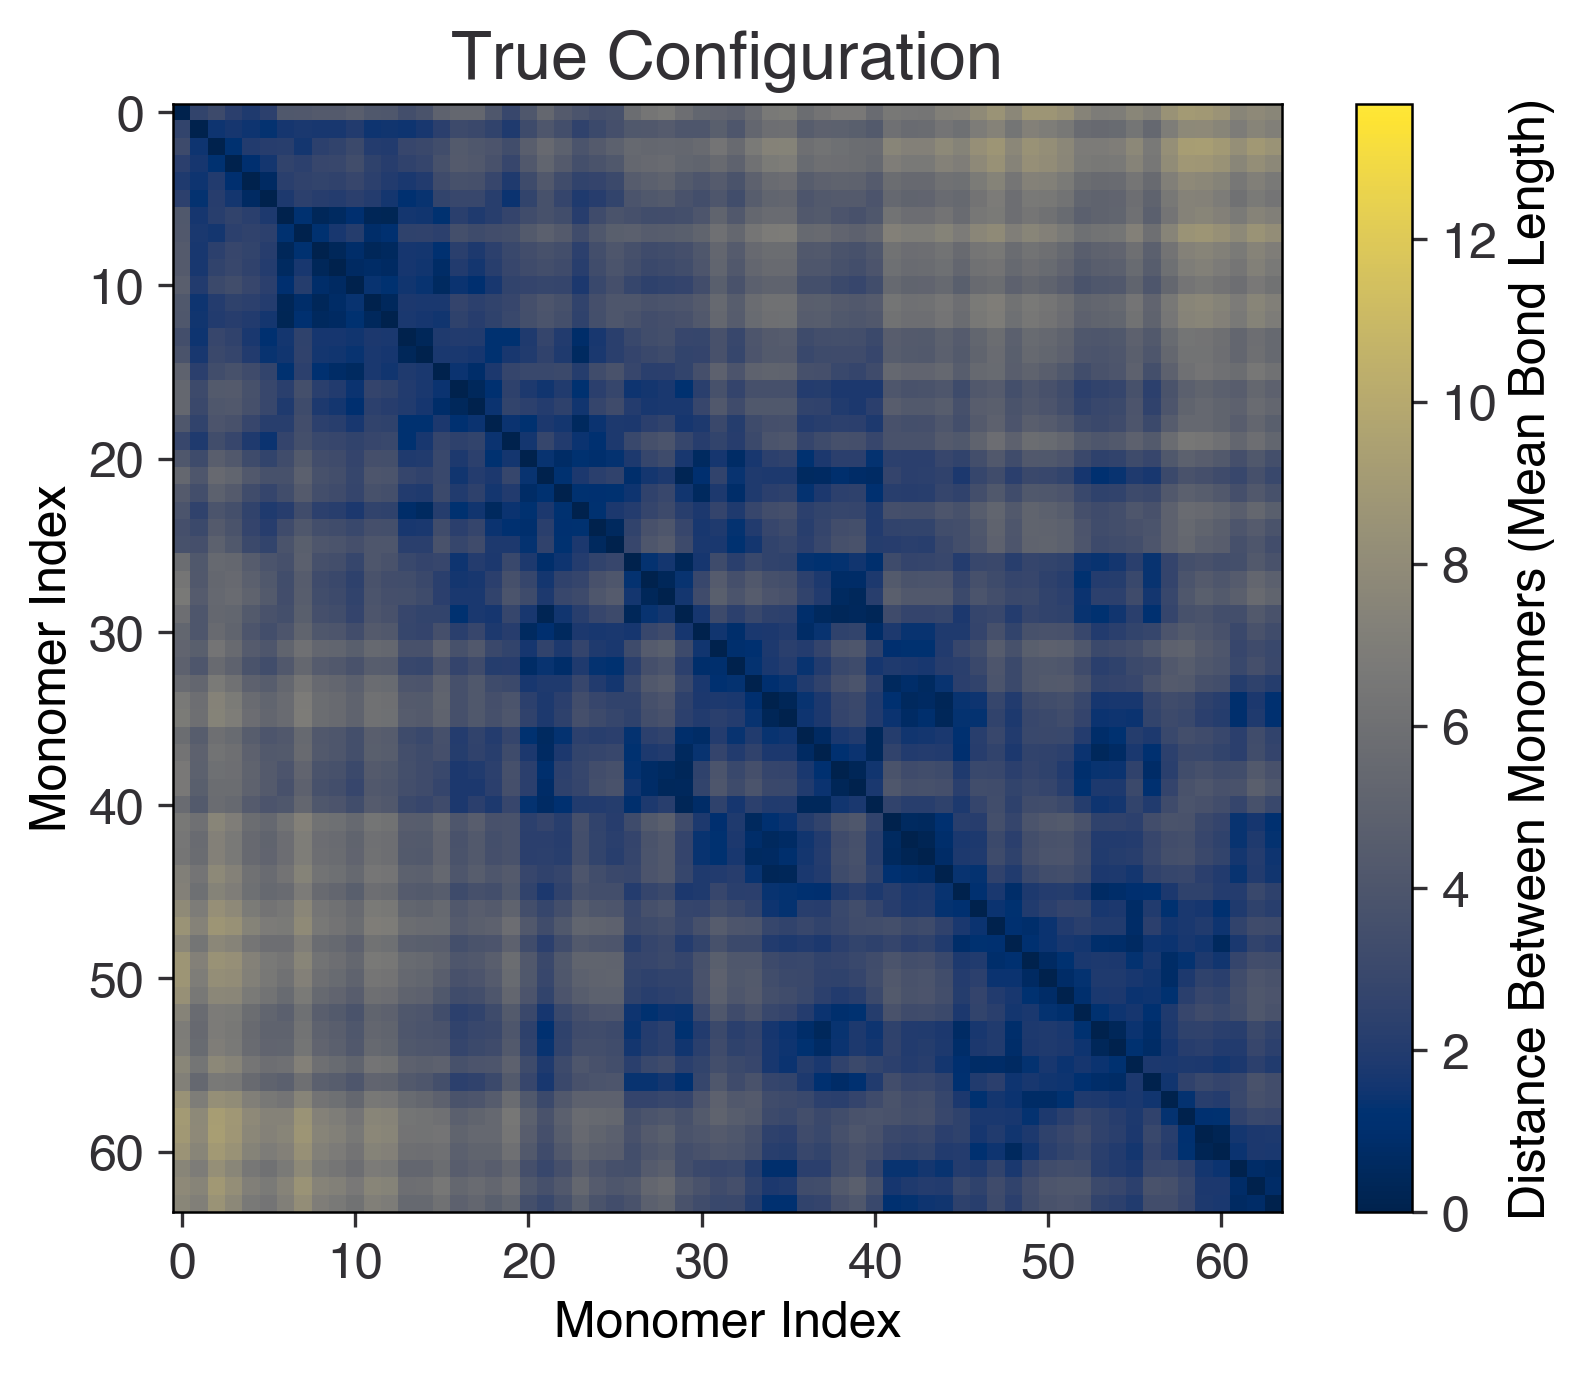

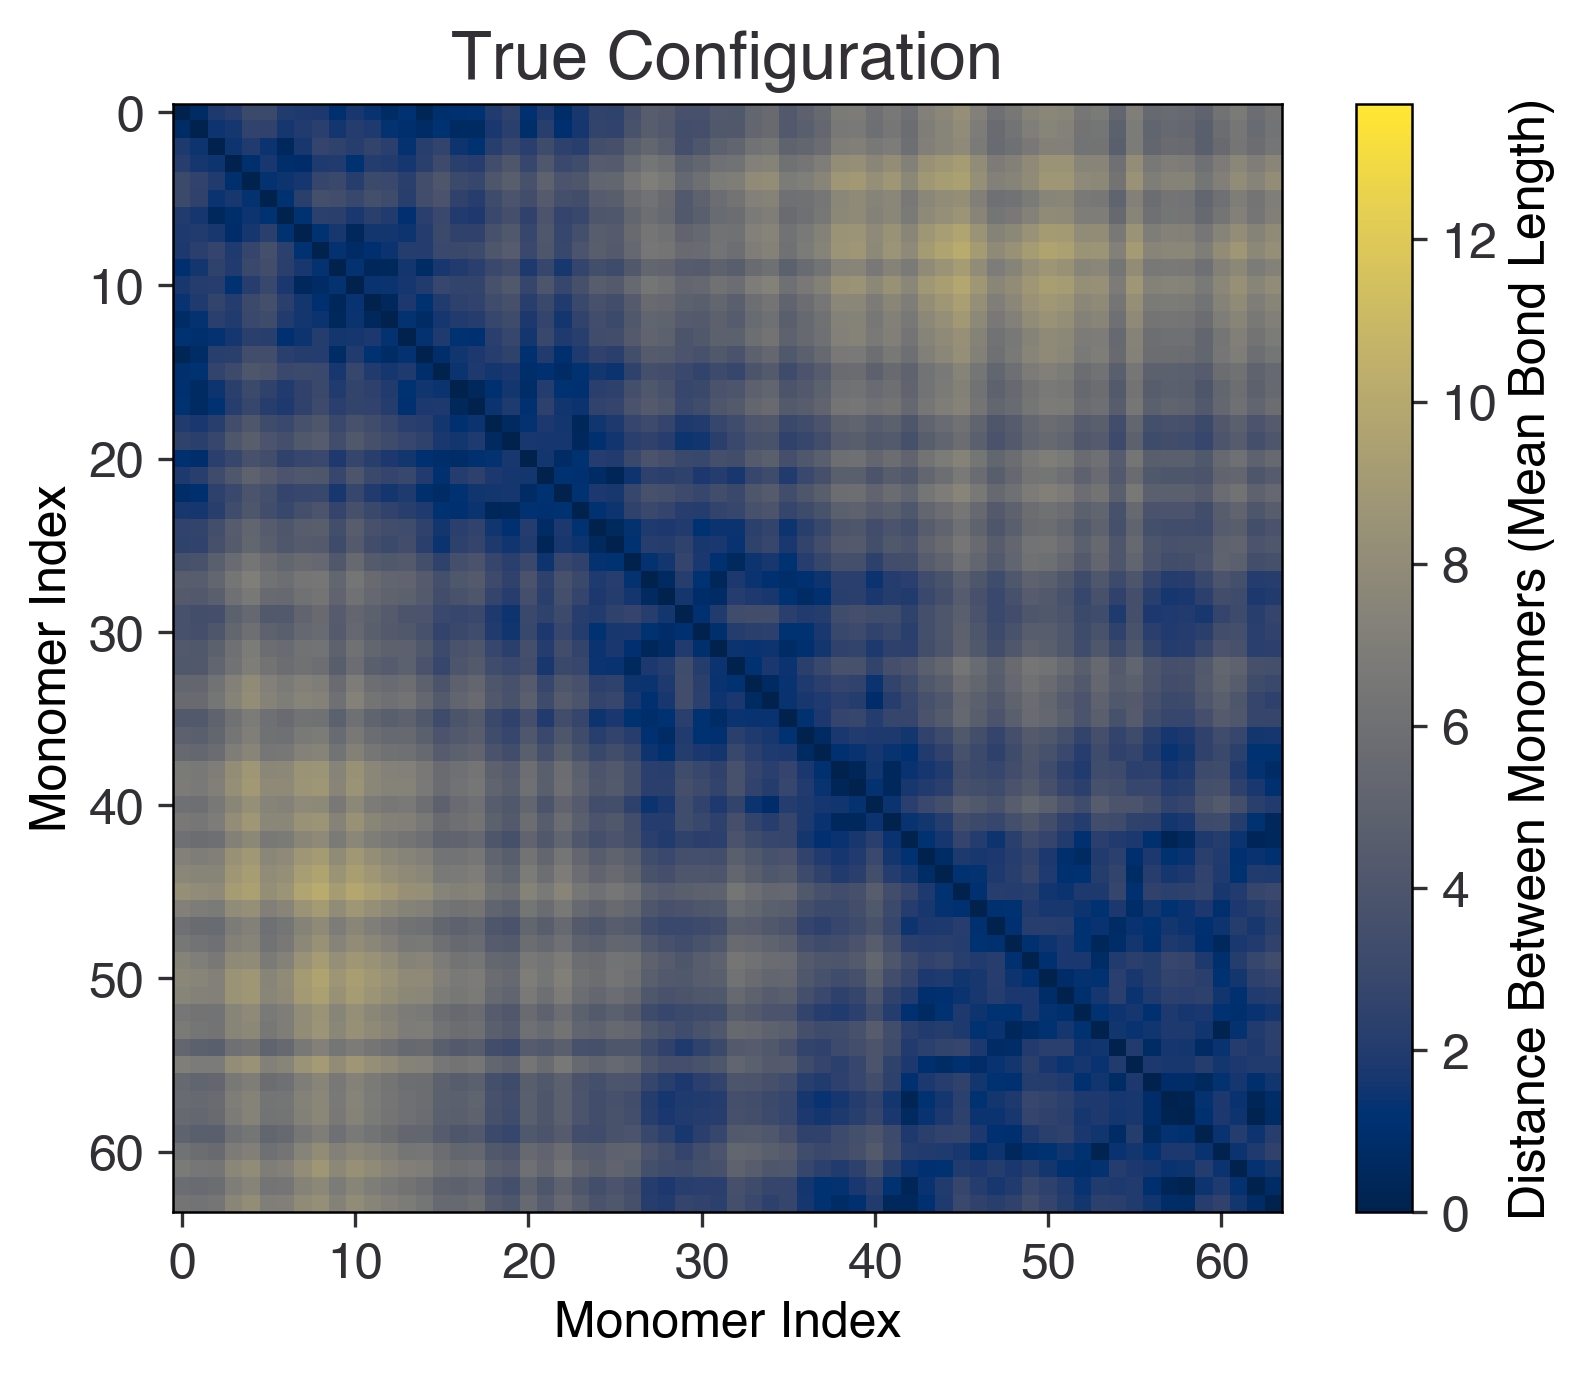

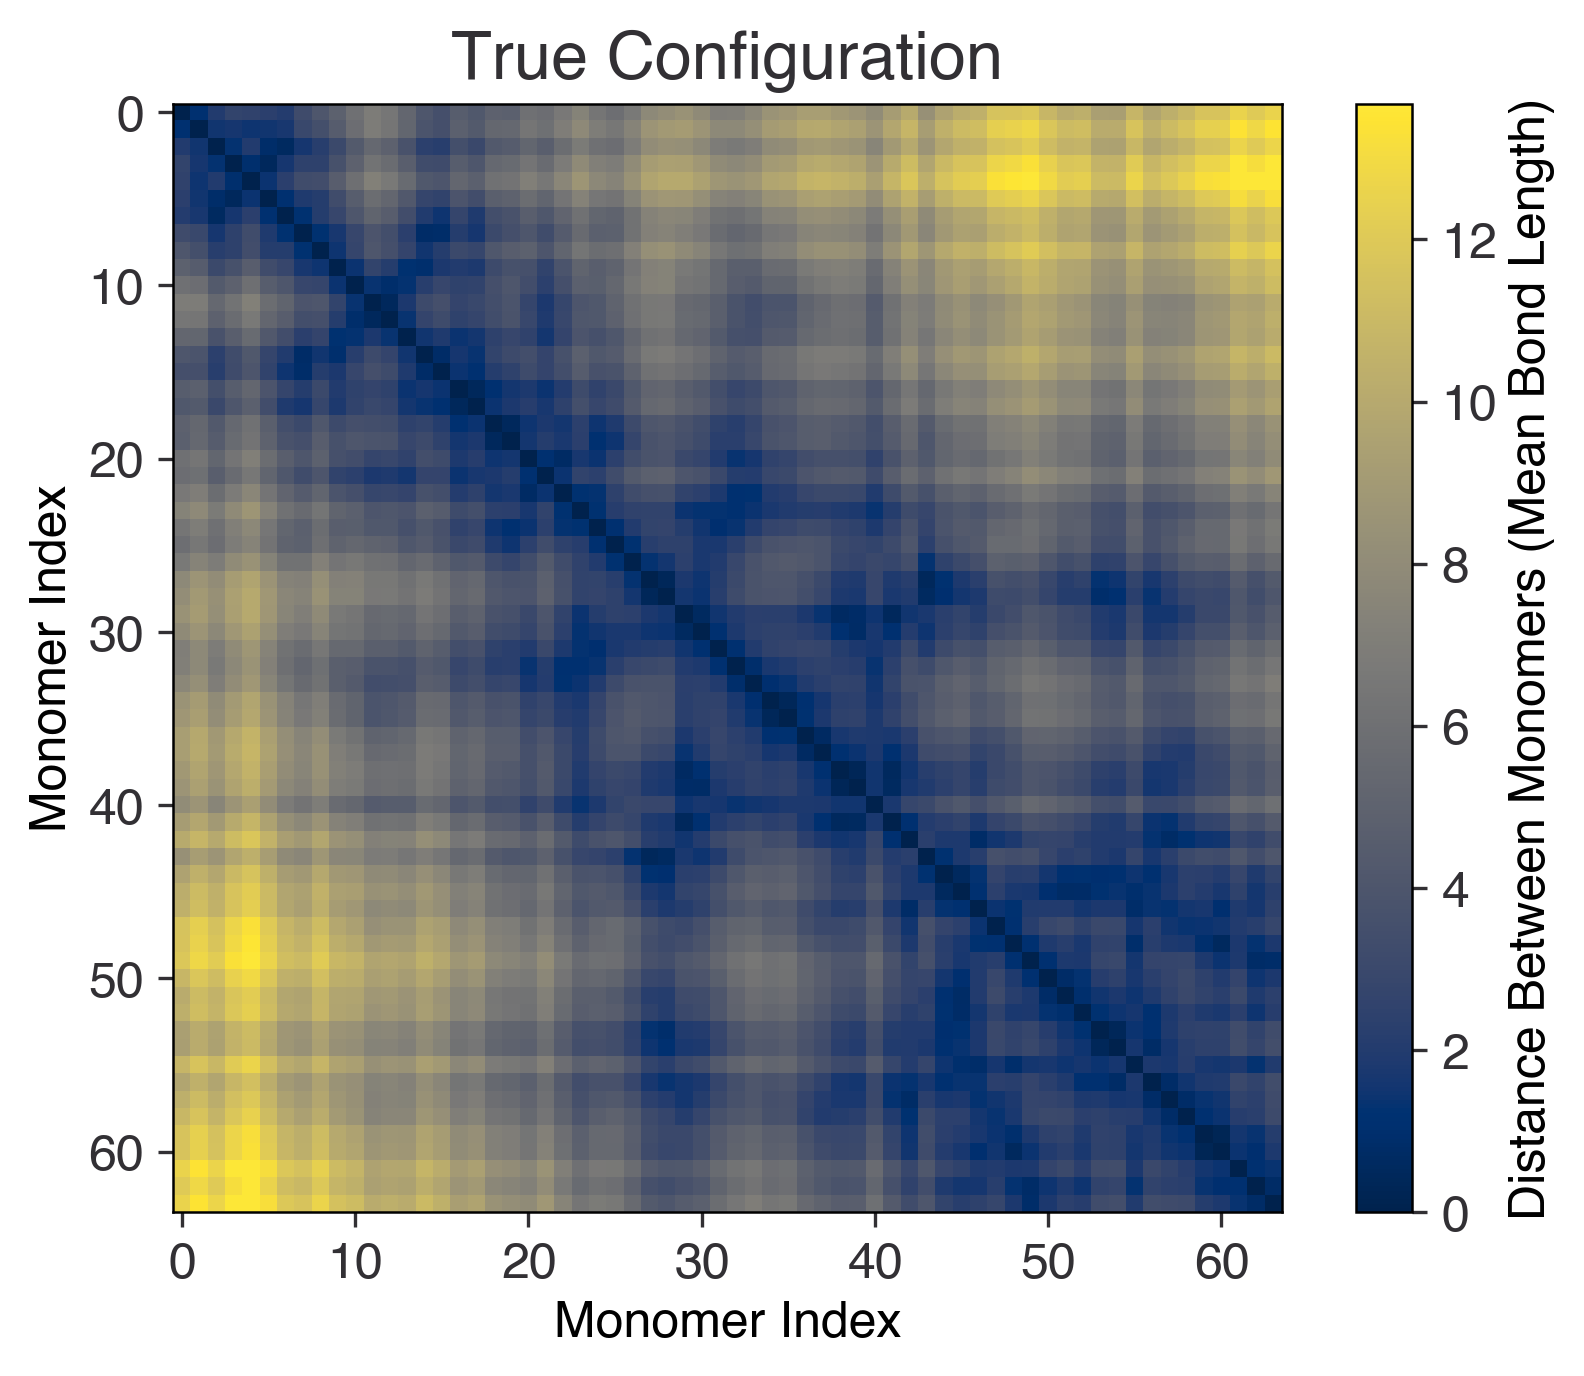

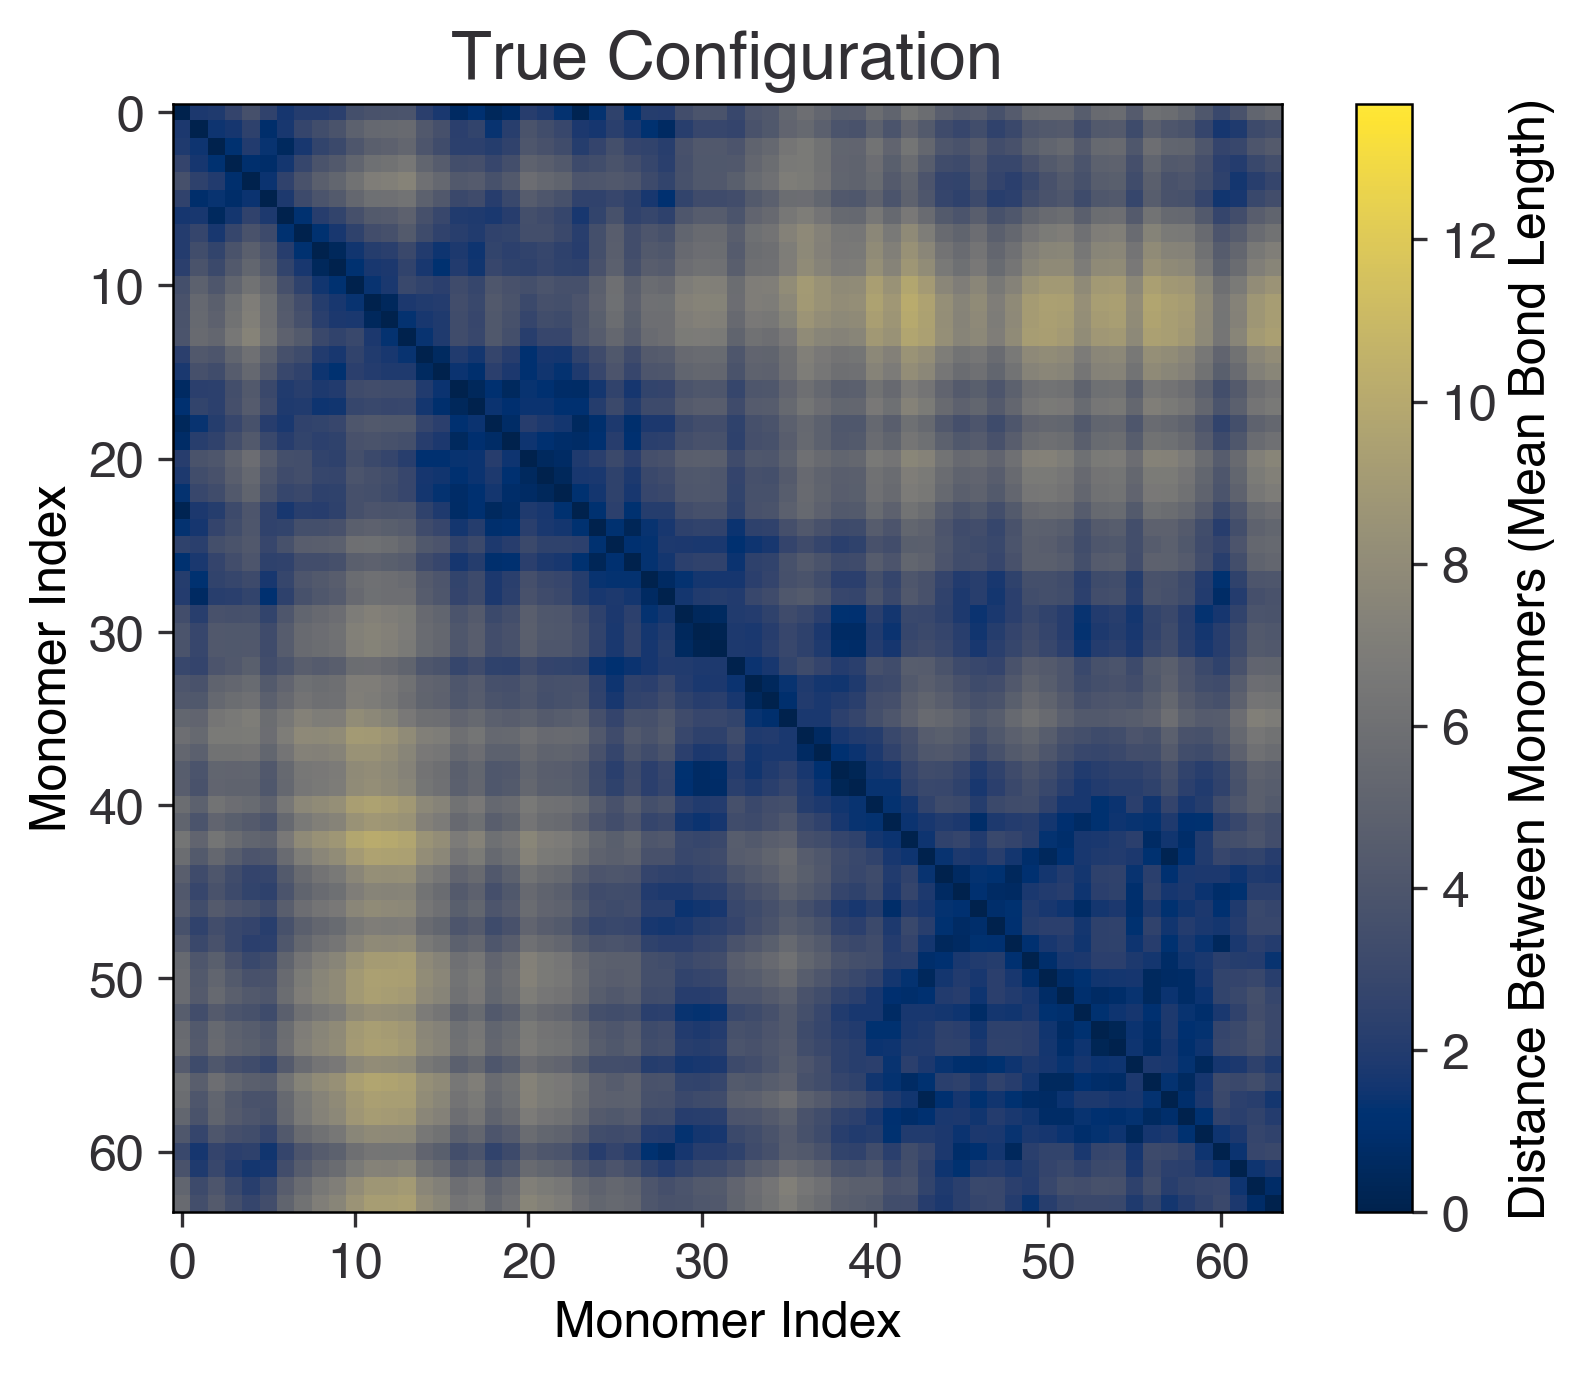

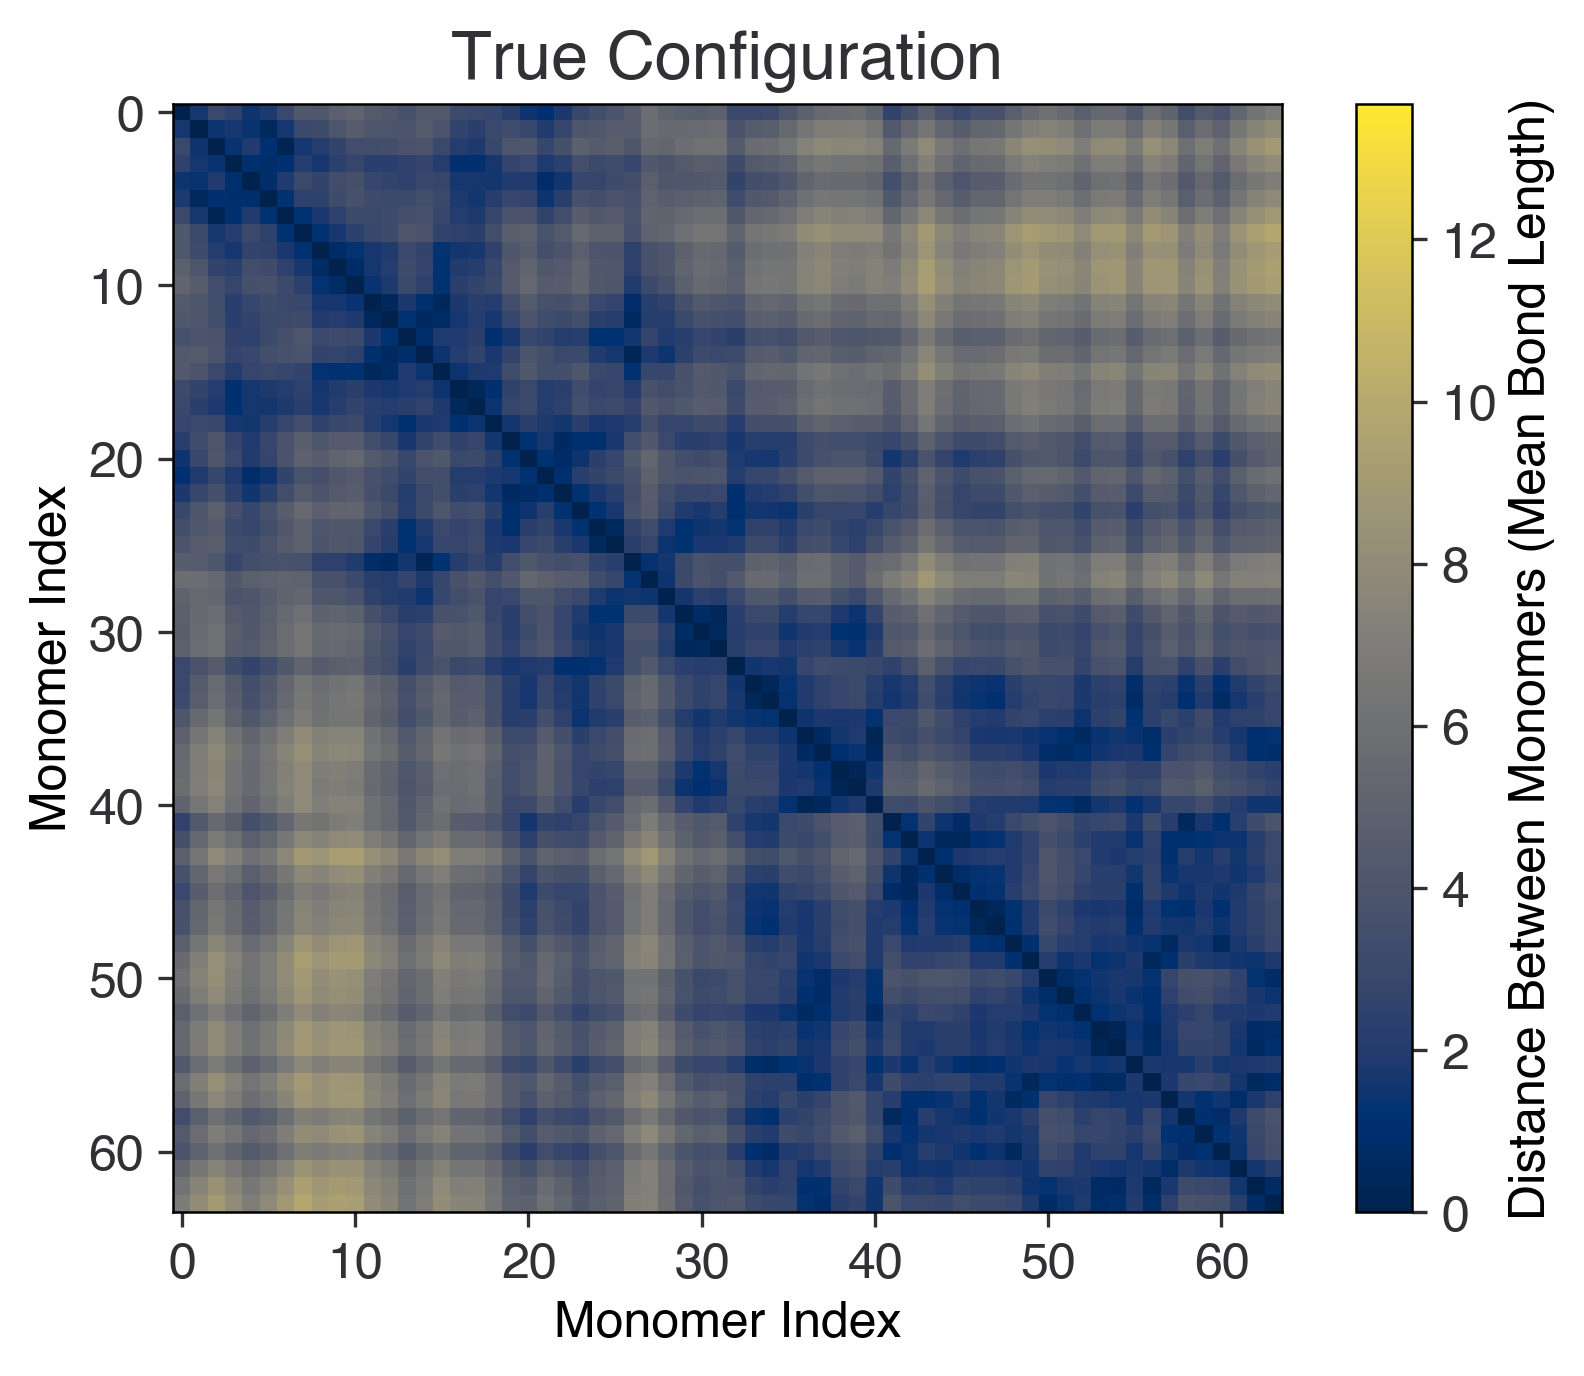

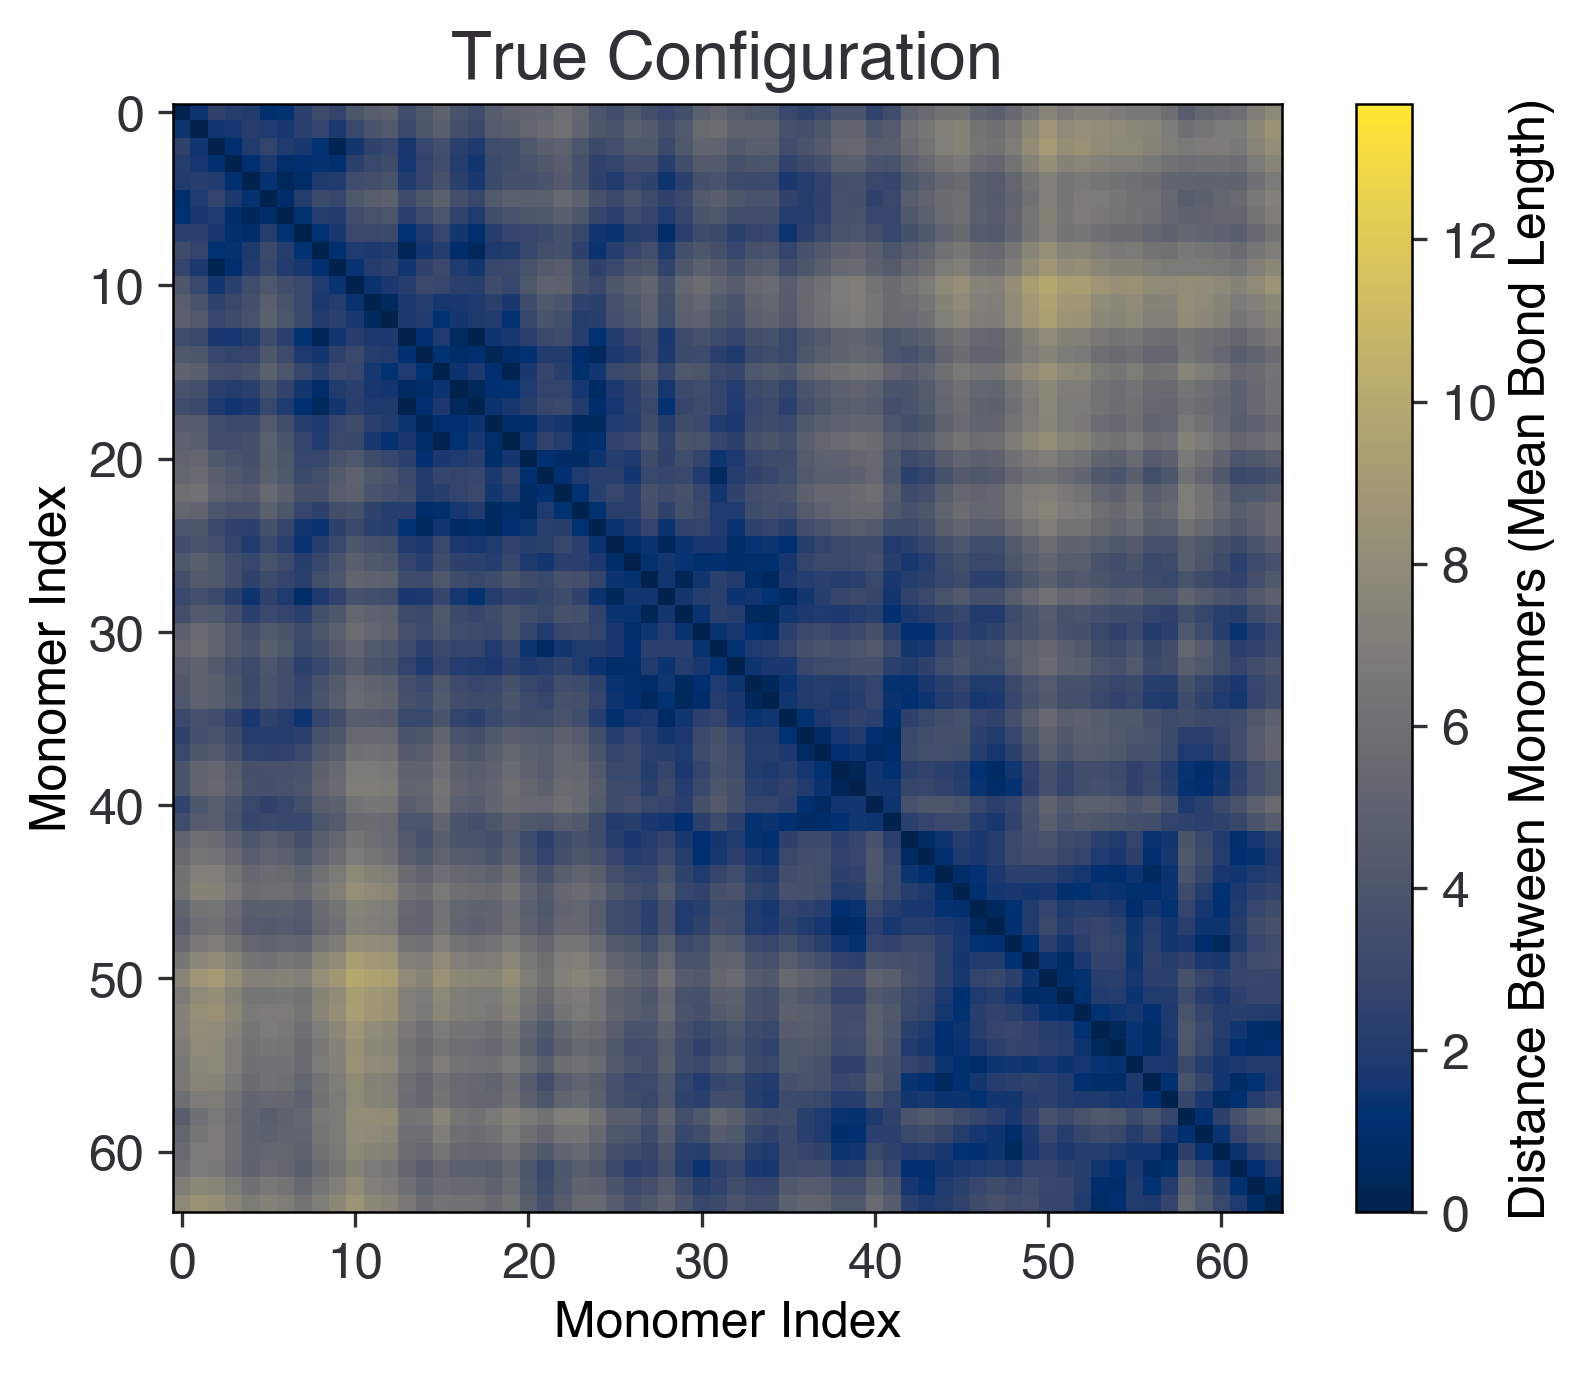

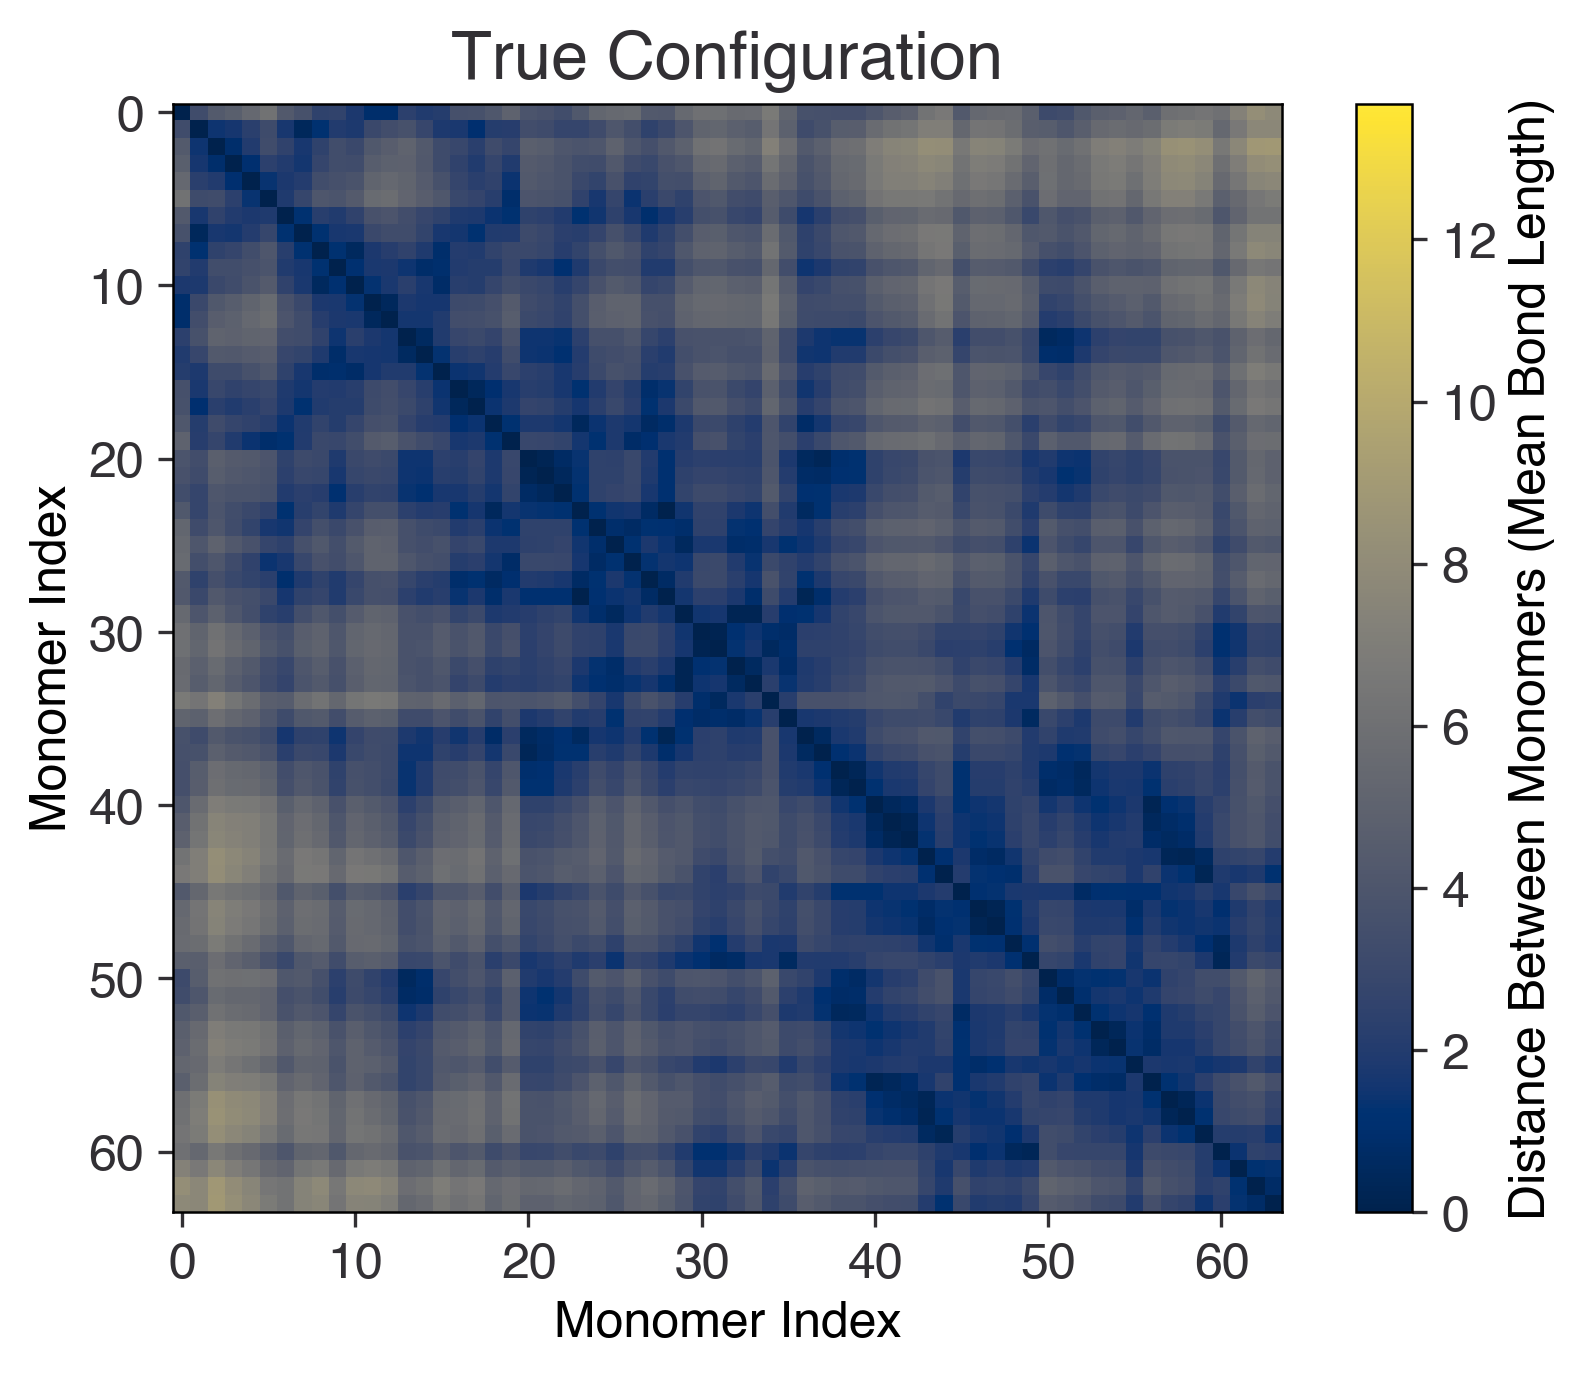

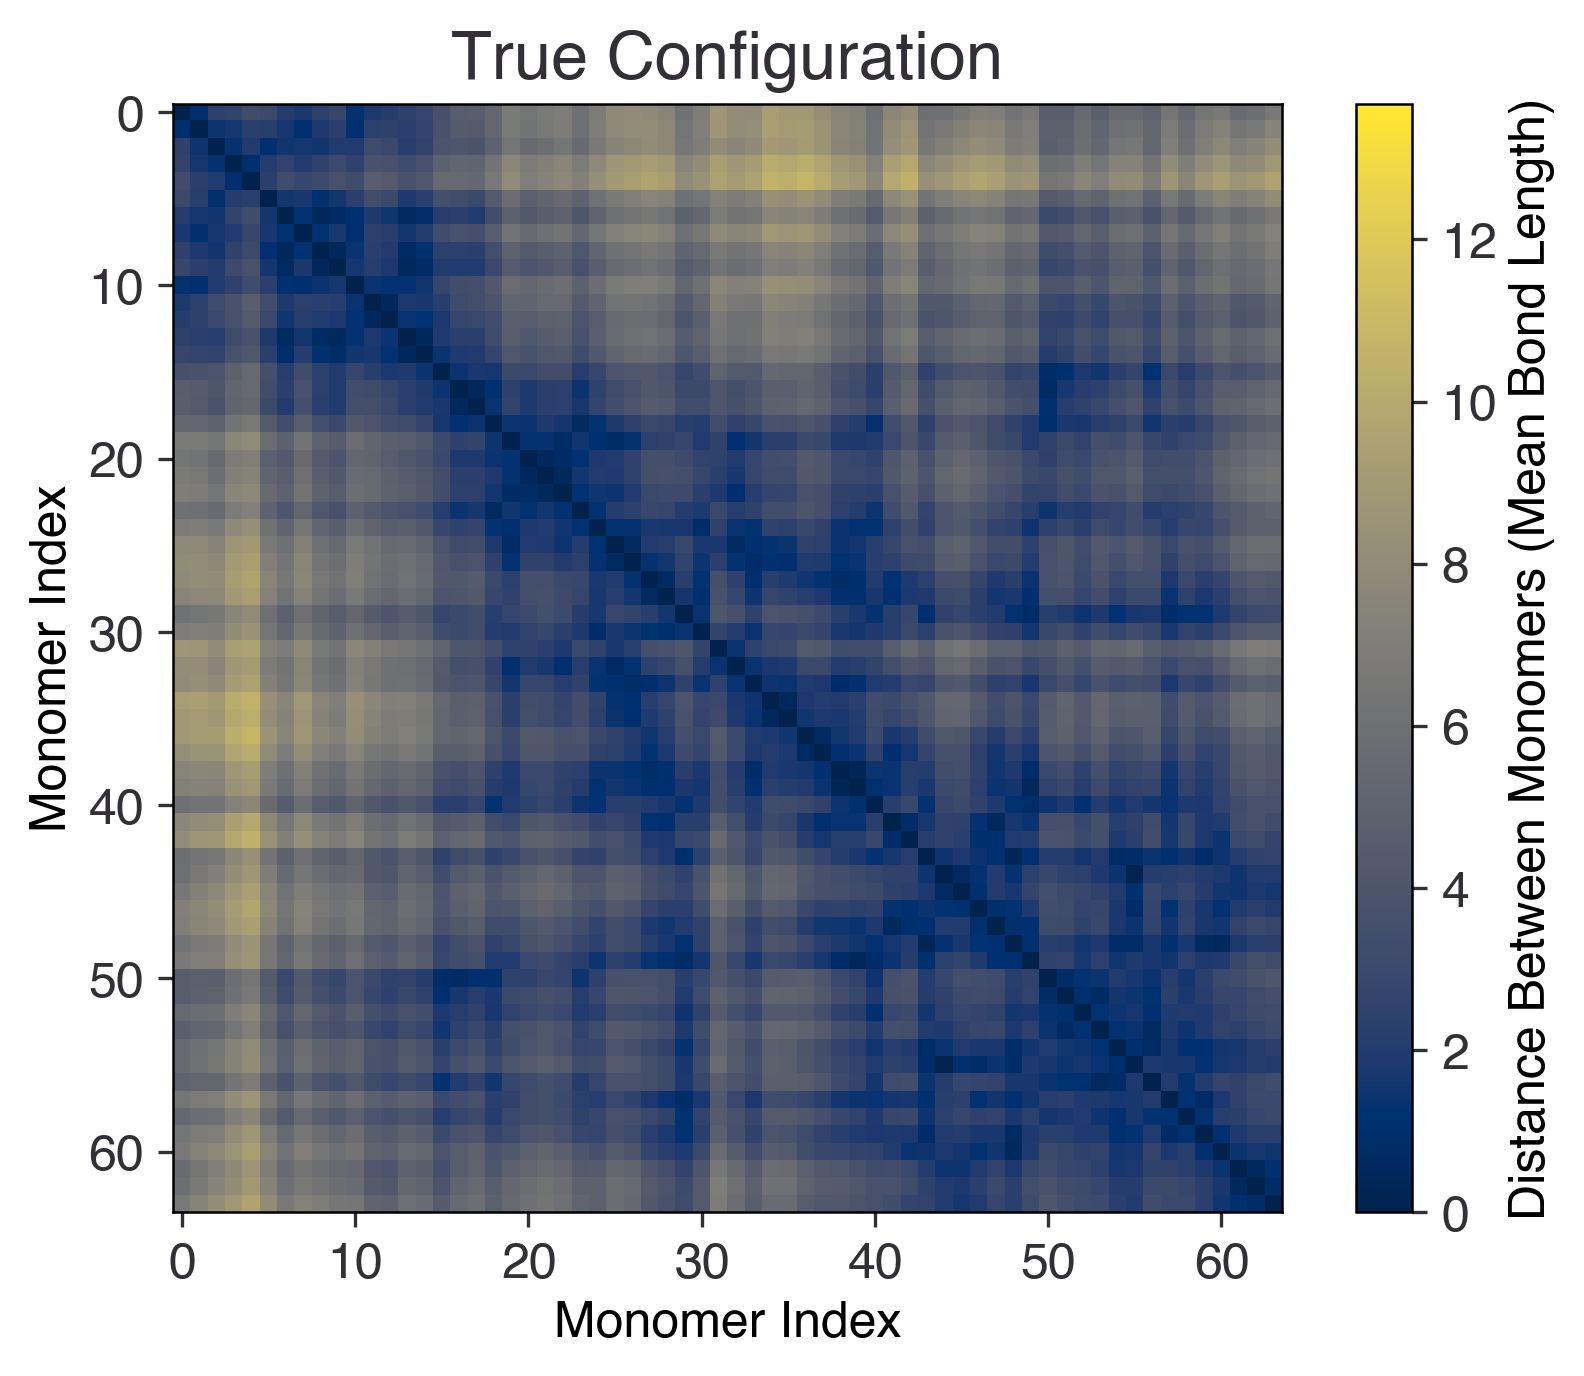

In [18]:
for i in range(10):
    fig,ax,*_ = plot_dists(recon[i,0,...])
    ax.set_title('True Configuration')

#fig.savefig('dist_map.pdf')

In [22]:
recon.shape

torch.Size([100, 1, 64, 64])

In [23]:
desired_config.shape

torch.Size([64, 64])

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 38 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'L', 'M', 'T', 'a', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'i', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'w', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 19, 20, 21, 22, 23, 24, 25, 27, 37, 38, 39, 44, 47, 48, 55, 68, 70, 71, 72, 73, 74, 75, 76, 80, 81, 82, 85, 86, 87, 88, 90, 91]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 39 glyphs after
INFO:fontTools.subset:Glyph names: ['.notde

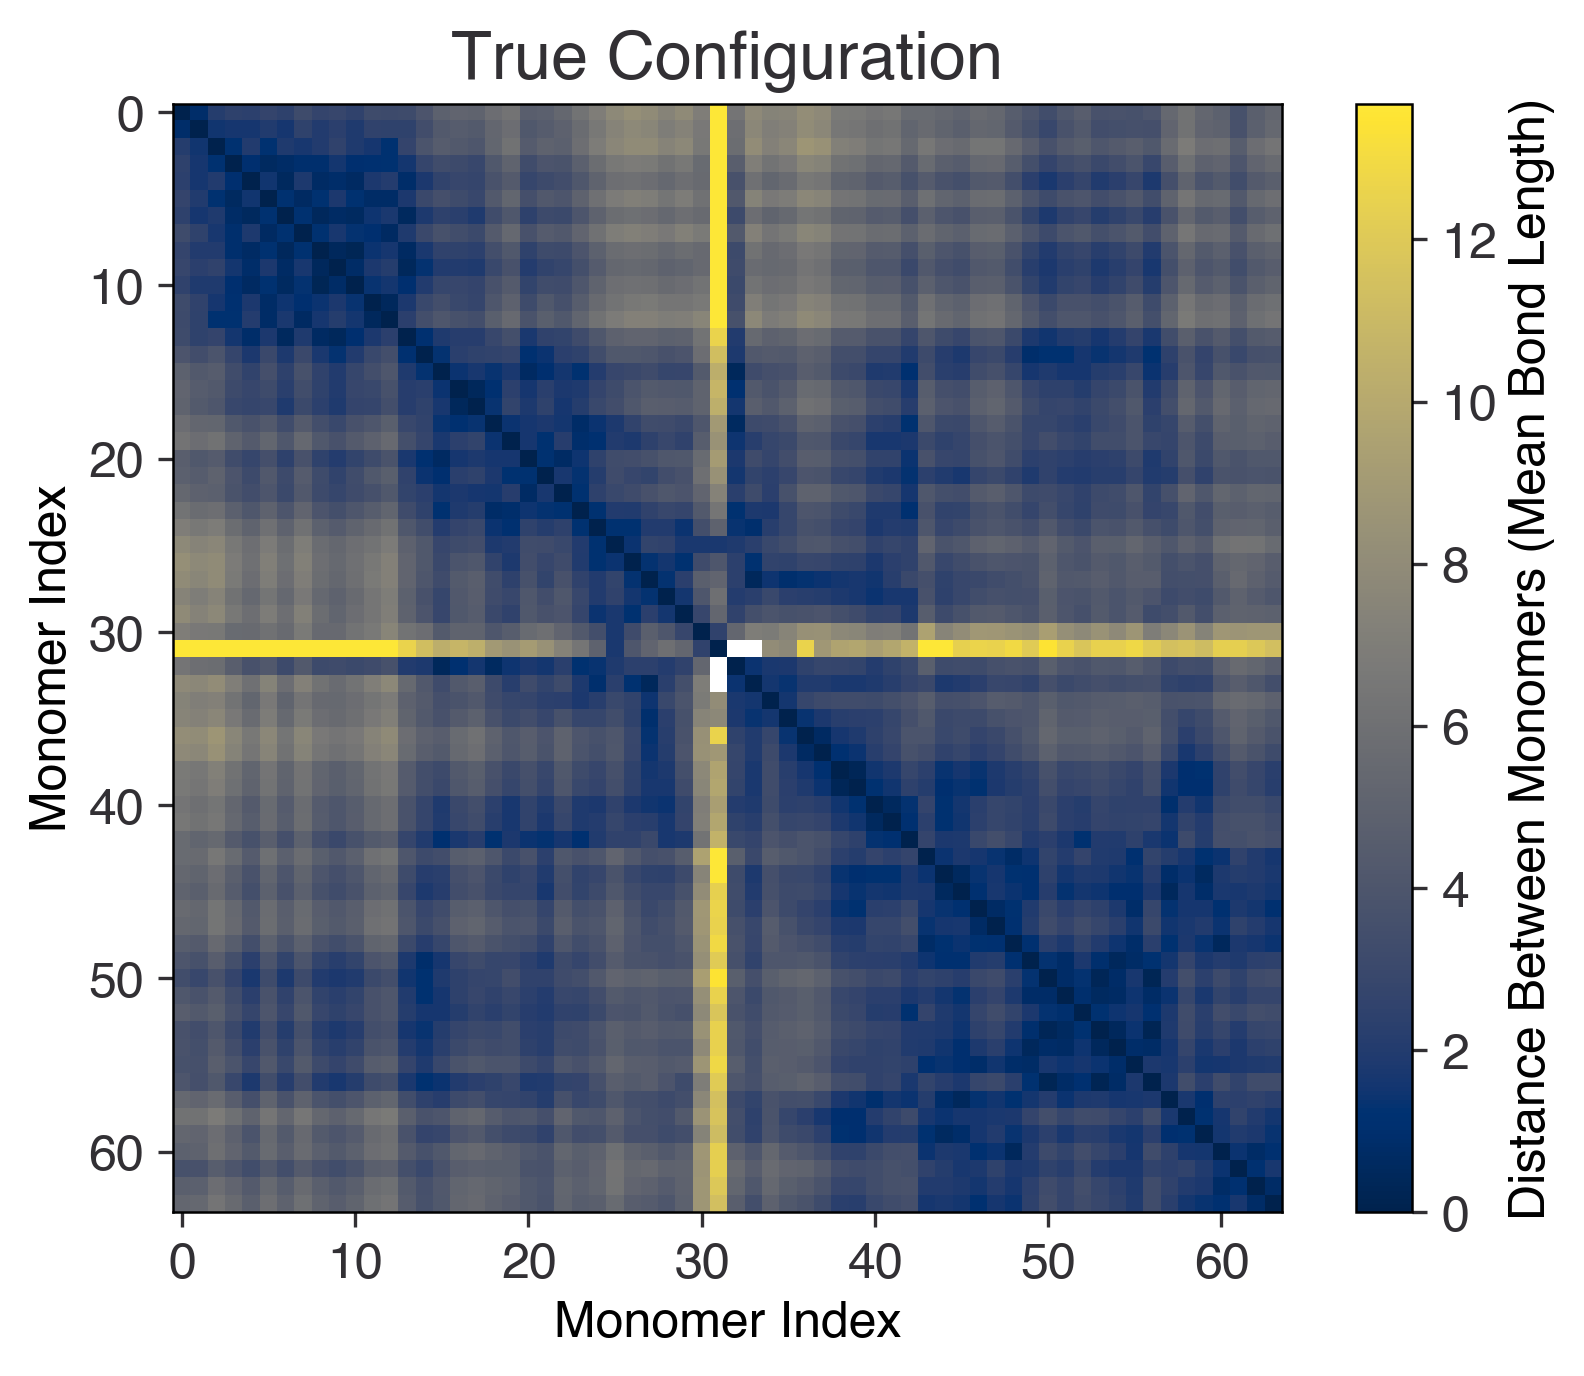

In [19]:
i=0
fig,ax,*_ = plot_dists(recon[i,0,...])
ax.set_title('True Configuration')

fig.savefig(f'dist_map_recon_{i}.pdf')

In [25]:
i=9
fig,ax,*_ = plot_dists(recon[i,0,...])
ax.set_title('True Configuration')

fig.savefig(f'dist_map_recon_{i}.pdf')

IndexError: index 395 is out of bounds for dimension 0 with size 100

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 38 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'C', 'D', 'I', 'L', 'M', 'T', 'a', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'i', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'w', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 19, 20, 21, 22, 23, 24, 25, 27, 37, 38, 39, 44, 47, 48, 55, 68, 70, 71, 72, 73, 74, 75, 76, 80, 81, 82, 85, 86, 87, 88, 90, 91]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 39 glyphs after
INFO:fontTools.subset:Glyph names: ['.notde

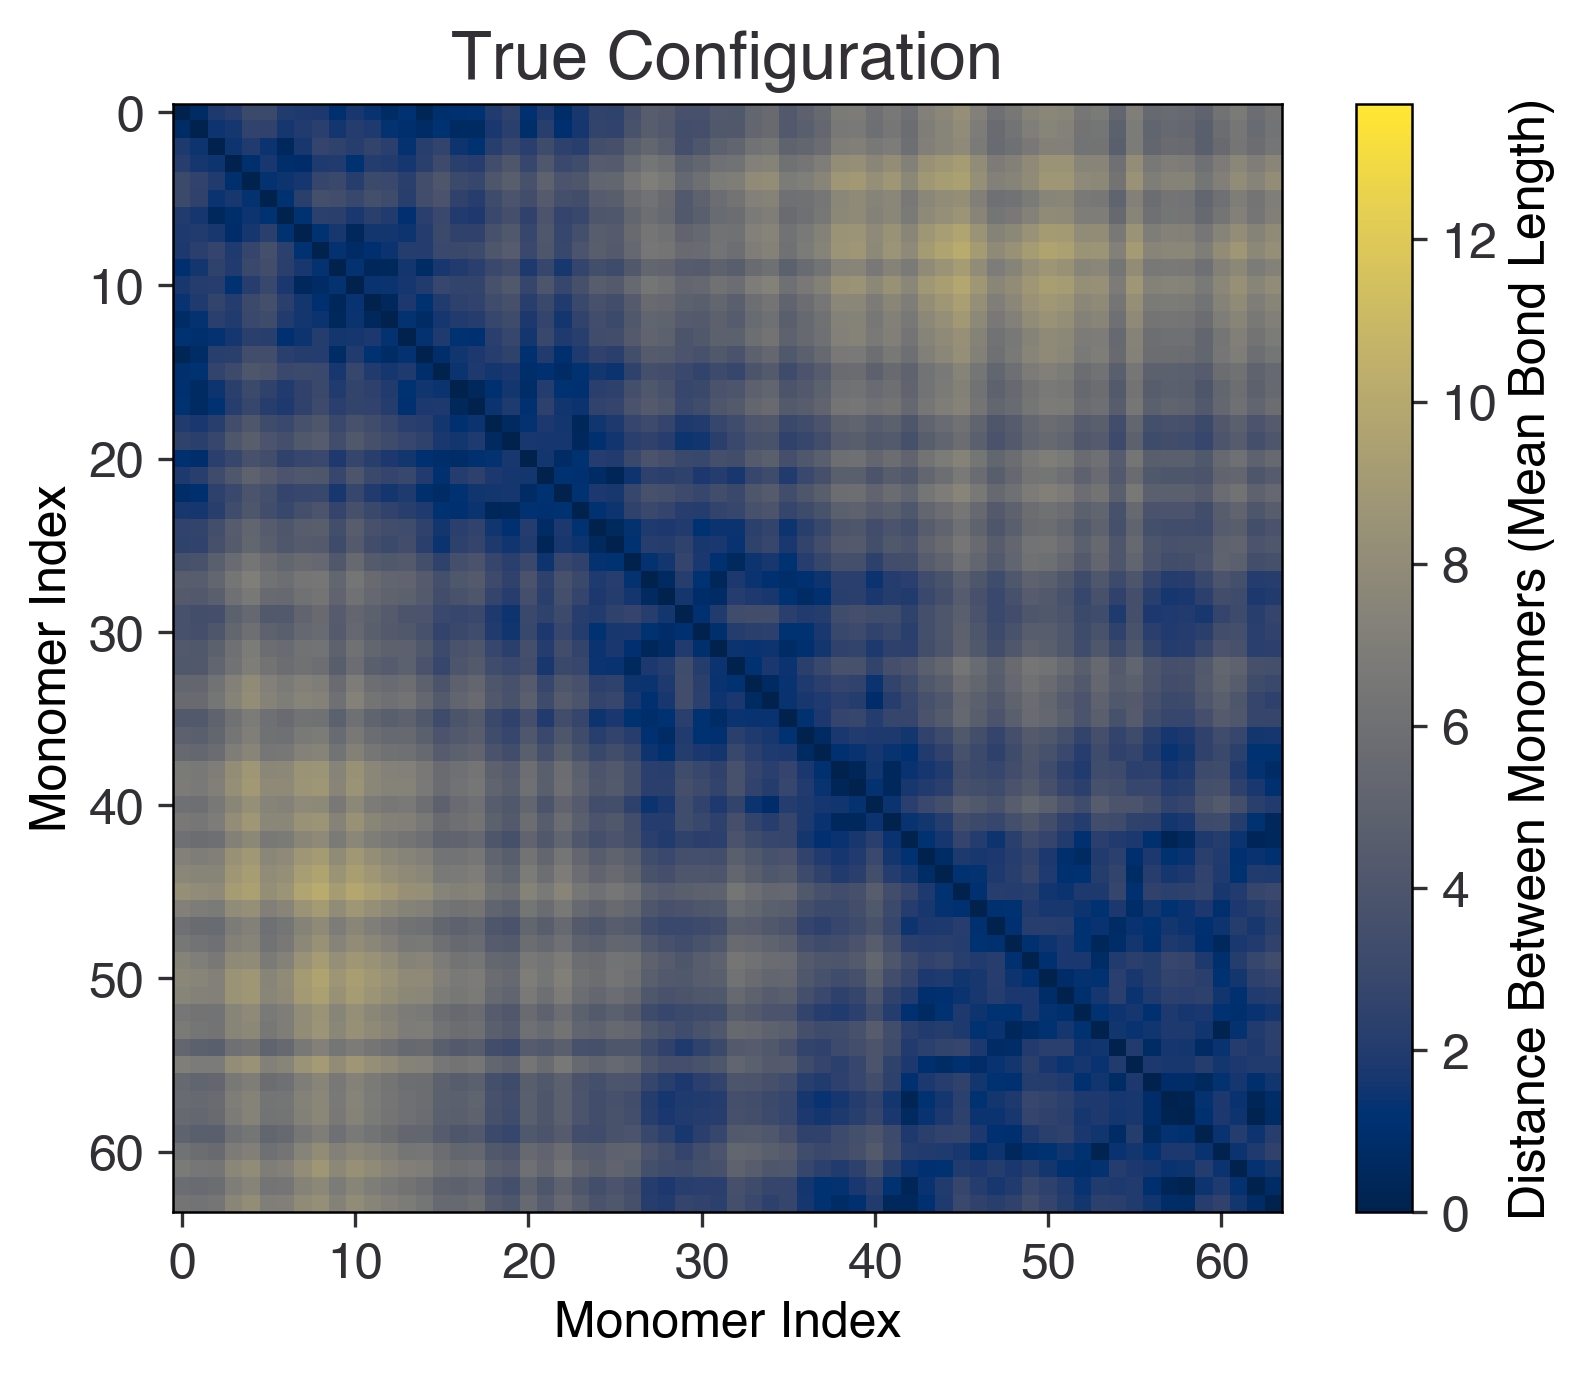

In [21]:
i=3
fig,ax,*_ = plot_dists(recon[i,0,...])
ax.set_title('True Configuration')

fig.savefig(f'dist_map_recon_{i}.pdf')

In [ ]:
# Set the properties to generate scHi-C map
r_c = 2
p_drop = .5#0.

# Get the config
desired_config = fetch_config(region_idx,chrom)

# Make a copy for the model 
config_for_model = desired_config.clone()

# Unnormalize the desired fig for plotting purposes
if remove_diagonal:
    desired_config = Sample(data = desired_config)
else:
    desired_config = Sample(data = remove_diagonal_fcn(desired_config))
desired_config.unnormalize_()
desired_config = add_diagonal_fcn(desired_config.unflatten())

# Create a scHi-C mask 
if remove_diagonal:
    keep_mask = remove_diagonal_fcn(desired_config) < r_c
else:
    keep_mask = desired_config < r_c    
keep_mask[torch.rand_like(desired_config) < p_drop] = False

# Manipulate the objects' shapes for use in the diffusion model
if use_origami:
    config_for_model = origami_transform(config_for_model)
    keep_mask_for_model = origami_transform(keep_mask)
else: 
    config_for_model = desired_config.clone()
    keep_mask_for_model = keep_mask.clone()



INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 34 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'D', 'I', 'L', 'M', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'g', 'h', 'i', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 'r', 's', 'six', 'space', 't', 'three', 'two', 'w', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 19, 20, 21, 22, 23, 24, 25, 27, 37, 39, 44, 47, 48, 68, 70, 71, 72, 74, 75, 76, 80, 81, 82, 85, 86, 87, 90, 91]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 34 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'D', 'I', 'L', 'M'

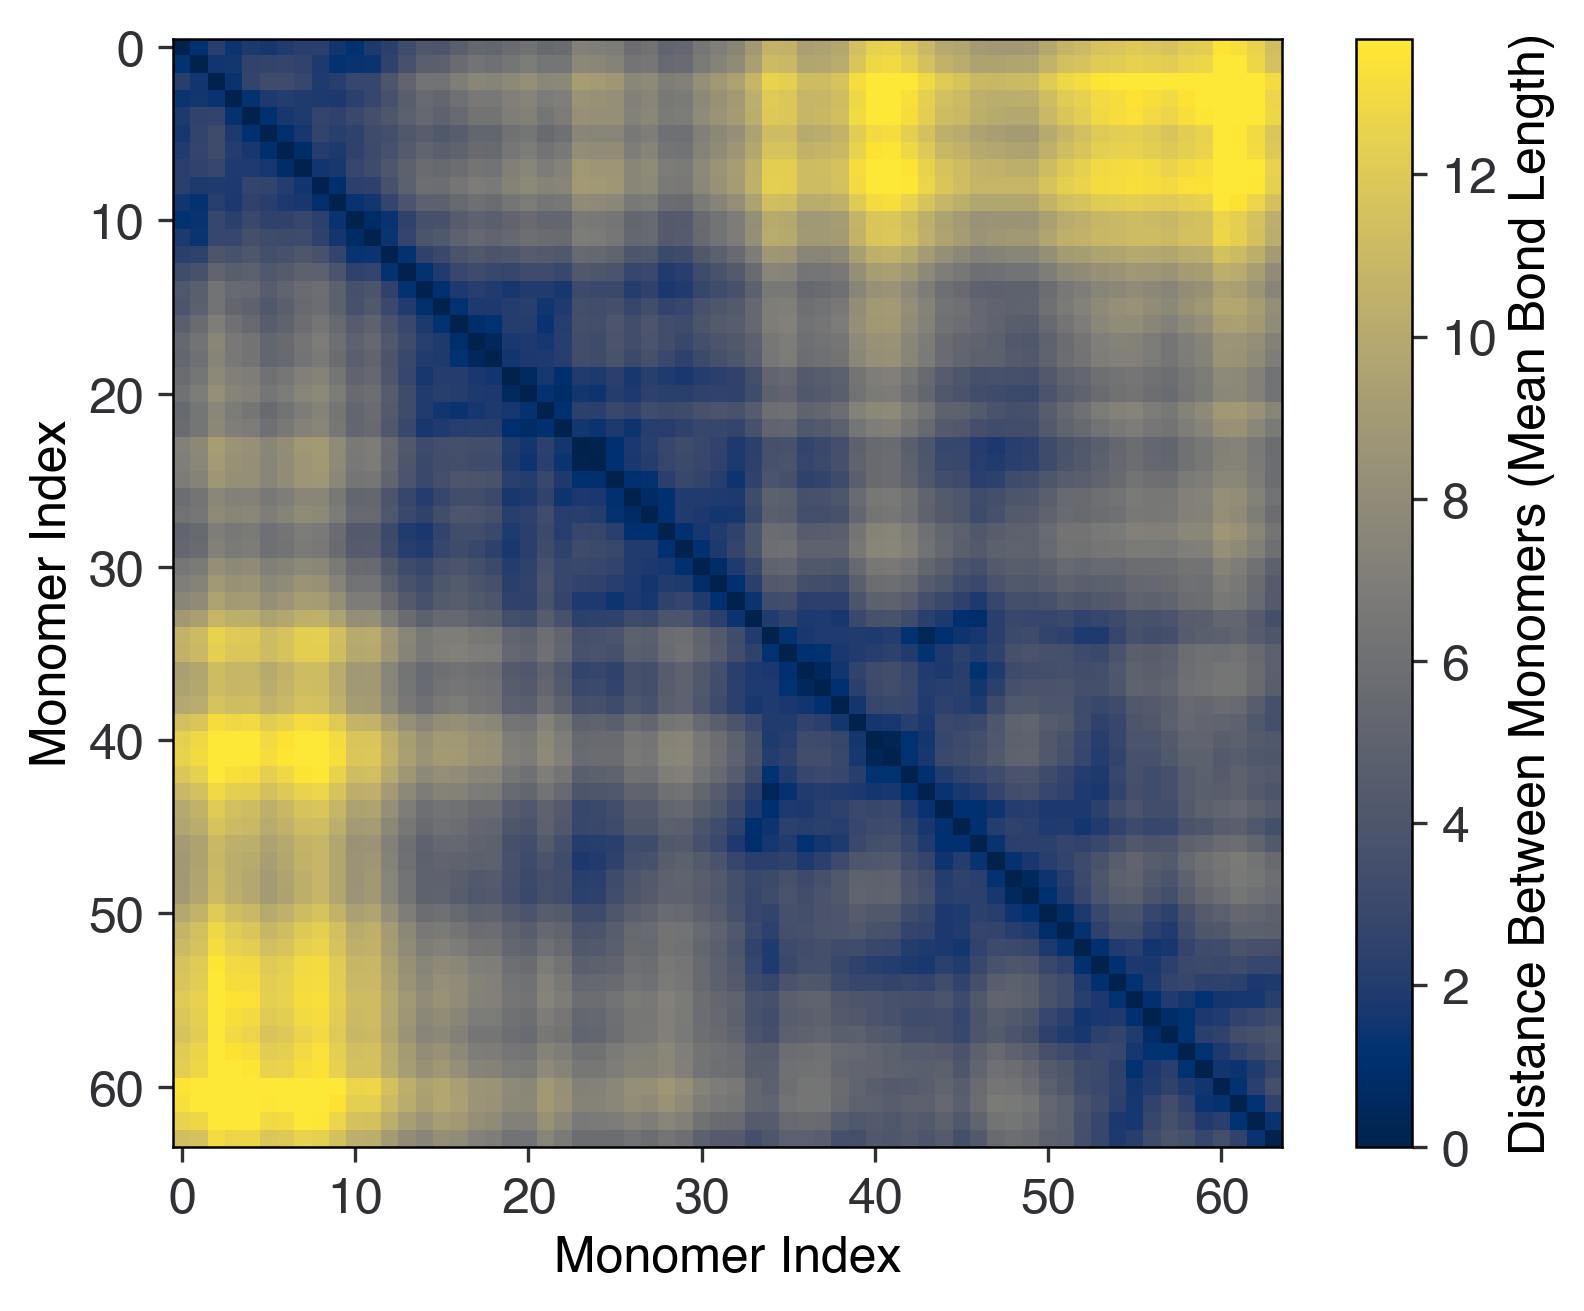

In [36]:
# Set the properties to generate scHi-C map
r_c = 2
p_drop = .5#0.

# Get the config
desired_config1 = fetch_config(395,chrom)

# Unnormalize the desired fig for plotting purposes
if remove_diagonal:
    desired_config1 = Sample(data = desired_config1)
else:
    desired_config1 = Sample(data = remove_diagonal_fcn(desired_config1))
desired_config1.unnormalize_()
desired_config1 = add_diagonal_fcn(desired_config1.unflatten())

fig,ax,*_ = plot_dists(desired_config1)
#ax.set_title('True Configuration')

fig.savefig('dist_map_true1.pdf')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 34 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'D', 'I', 'L', 'M', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'g', 'h', 'i', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'parenleft', 'parenright', 'r', 's', 'six', 'space', 't', 'three', 'two', 'w', 'x', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 11, 12, 19, 20, 21, 22, 23, 24, 25, 27, 37, 39, 44, 47, 48, 68, 70, 71, 72, 74, 75, 76, 80, 81, 82, 85, 86, 87, 90, 91]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 34 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'B', 'D', 'I', 'L', 'M'

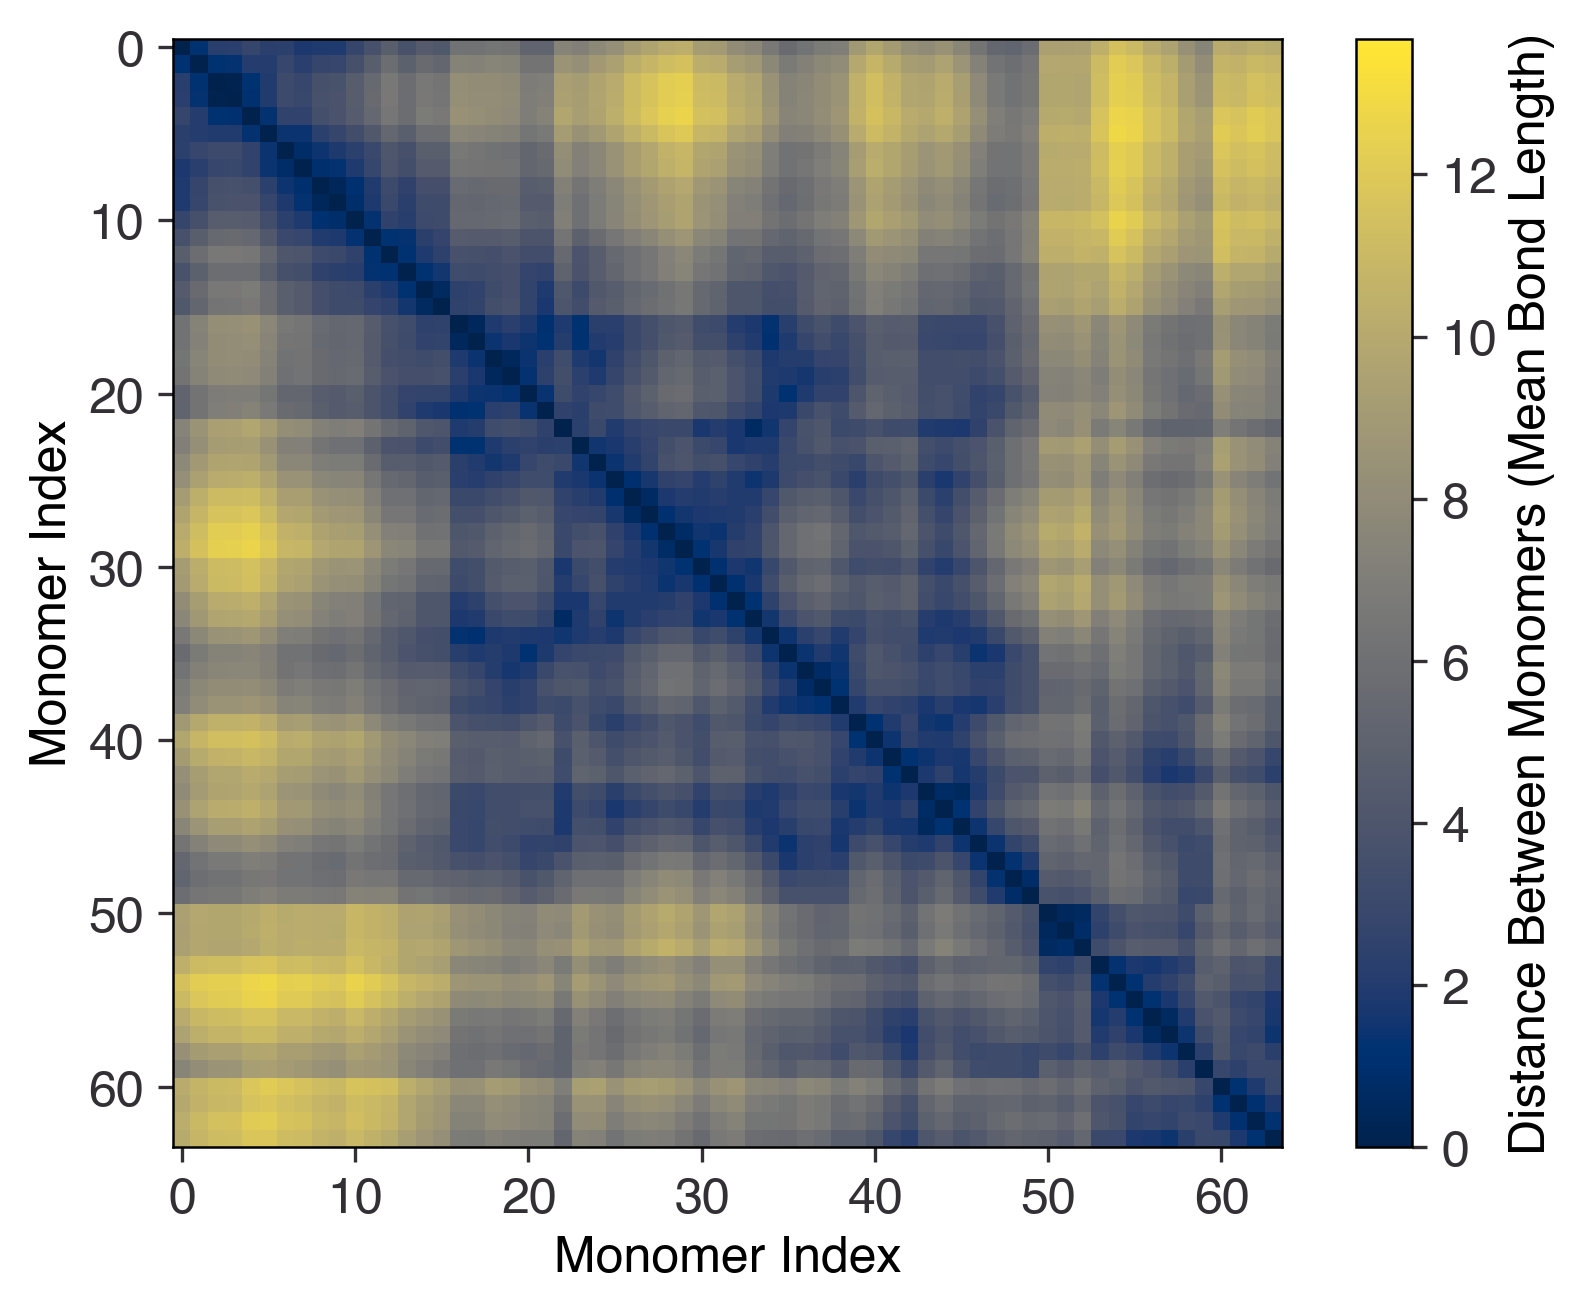

In [38]:
# Set the properties to generate scHi-C map
r_c = 2
p_drop = .5#0.

# Get the config
desired_config1 = fetch_config(460,chrom)

# Unnormalize the desired fig for plotting purposes
if remove_diagonal:
    desired_config1 = Sample(data = desired_config1)
else:
    desired_config1 = Sample(data = remove_diagonal_fcn(desired_config1))
desired_config1.unnormalize_()
desired_config1 = add_diagonal_fcn(desired_config1.unflatten())

fig,ax,*_ = plot_dists(desired_config1)
#ax.set_title('True Configuration')

fig.savefig('dist_map_true2.pdf')